# INM430 - Data Science Project


***

** Student Name: ** __Sarah FREMOND__

** Project Title:** __To what extent Yelp is a powerful indicator - a study case in Arizona__

***


# 0. Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# usual libraries
import pandas as pd
import json
import random
from collections import Counter
import numpy as np
from scipy import stats
from pprint import pprint

In [3]:
# visual libraries
%matplotlib inline
import folium
from folium.plugins import HeatMap
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh

In [4]:
#librairies of text preprocessing
import re
#import contractions
import unicodedata
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

In [5]:
#libraries from scikit learn
from sklearn.metrics.pairwise import cosine_similarity, haversine_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [6]:
import gensim
from wordcloud import WordCloud
from textblob import TextBlob
from fastdtw import fastdtw
from numpy.linalg import norm
from scipy.sparse import hstack
from scipy.spatial.distance import cdist

# 1. Loading data

The data have been downloaded from Yelp website.

## 1.1 business.json file

In [7]:
with open('./yelp_dataset/business.json', encoding="utf8") as f:
    data = f.readlines()
    data_ = [json.loads(line) for line in data] #convert string to dict format
business = pd.read_json(json.dumps(data_)) # Load into dataframe
del data
del data_

## 1.2 review_arizona.json file

this will be used later on

In [8]:
%time review_arizona = pd.read_json('./yelp_dataset/review_arizona_json.json')

Wall time: 22.9 s


# 2. Initial analysis of the file business.json

In [9]:
business.head(3)

business_id                         name  \
0  1SWheh84yJXfytovILXOAQ   Arizona Biltmore Golf Club   
1  QXAEGFB4oINsVuTFxEYKFQ   Emerald Chinese Restaurant   
2  gnKjwL_1w79qoiV3IC_xQQ  Musashi Japanese Restaurant   

                       address         city state postal_code   latitude  \
0  2818 E Camino Acequia Drive      Phoenix    AZ       85016  33.522143   
1         30 Eglinton Avenue W  Mississauga    ON     L5R 3E7  43.605499   
2    10110 Johnston Rd, Ste 15    Charlotte    NC       28210  35.092564   

    longitude  stars  review_count  is_open  \
0 -112.018481    3.0             5        0   
1  -79.652289    2.5           128        1   
2  -80.859132    4.0           170        1   

                                          attributes  \
0                           {'GoodForKids': 'False'}   
1  {'RestaurantsReservations': 'True', 'GoodForMe...   
2  {'GoodForKids': 'True', 'NoiseLevel': 'u'avera...   

                                          categories  \
0                                  Golf, Active Life   
1  Specialty Food, Restaurants, Dim Sum, Imported...   
2                  Sushi Bars, Restaurants, Japanese   

                                               hours  
0                                               None  
1  {'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...  
2  {'Monday': '17:30-21:30', 'Wednesday': '17:30-...

In [10]:
business.describe()

latitude      longitude          stars   review_count  \
count  192609.000000  192609.000000  192609.000000  192609.000000   
mean       38.541803     -97.594785       3.585627      33.538962   
std         4.941964      16.697725       1.018458     110.135224   
min        33.204642    -115.493471       1.000000       3.000000   
25%        33.637408    -112.274677       3.000000       4.000000   
50%        36.144815    -111.759323       3.500000       9.000000   
75%        43.602989     -79.983614       4.500000      25.000000   
max        51.299943     -72.911982       5.000000    8348.000000   

             is_open  
count  192609.000000  
mean        0.823040  
std         0.381635  
min         0.000000  
25%         1.000000  
50%         1.000000  
75%         1.000000  
max         1.000000

__comments__ : The json business file downloaded from Yelp website contains basic information about businesses recorded in Yelp platform. We have mostly spatial information from coordinates, address, state, postal_code. We also get meaningful information from the Yelp overall score and the number of reviews. In average, businesses are getting 33 reviews and an overall star of 3.58 out of 5.

## 2.1 Cleaning

### 2.1.1 Duplicates

In [11]:
business[business.duplicated(['business_id'])]

Empty DataFrame
Columns: [business_id, name, address, city, state, postal_code, latitude, longitude, stars, review_count, is_open, attributes, categories, hours]
Index: []

__comments__: there is no duplicates based on the business id. Yelp dataset gets therefore 192 098 businesses that signed up.

### 2.1.2 Missing values

In [12]:
business.isnull().sum()

business_id         0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes      28836
categories        482
hours           44830
dtype: int64

__comments__ : Some missing values are found in the dataframe. They are all about attributes, categories and hours. Hours feature is not needed in this study so it's removed. Categories are lists of keywords explaining the type of business and this is used later. Hence observations with nan values in categories are removed. Regarding attributes, it will be used at the end of the analysis so it's left like this at this time.

In [13]:
business = business.drop(['hours'], axis=1) #column hours is removed
business.dropna(subset=['categories'], inplace=True) #rows with nan values in categories are removed.

### 2.1.3 Feature removing

Since longitute and latitude illustrates spatial information, address, postal_code and city are removed. States is kept to show some analysis.

In [14]:
business = business.drop(['postal_code', 'address', 'city'], axis=1) # remove postal_code, address, city

### 2.1.4 Feature re-naming

State information is useful for the first analysis. Short forms are changed into full names to help us identify the meaning of the state.

In [15]:
print(np.unique(business.state))

['AB' 'AK' 'AL' 'AR' 'AZ' 'BAS' 'BC' 'CA' 'CON' 'CT' 'DOW' 'DUR' 'FL' 'GA'
 'IL' 'NC' 'NE' 'NJ' 'NM' 'NV' 'NY' 'OH' 'ON' 'PA' 'QC' 'SC' 'TN' 'TX'
 'UT' 'VA' 'VT' 'WA' 'WI' 'XGL' 'XGM' 'XWY']


In [16]:
# we change the name of state to get a more meaningfull feature : 
states = {
    'AB': 'alberta', 
    'AK' : 'alaska',
    'AL': 'alabama',
    'AR': 'arkansas',
    'AZ' : 'arizona',
    'BAS' : 'ontario',
    'BC': 'ontario',
    'CA': 'california',
    'CON': 'north_carolina',
    'CT' : 'connecticut',
    'DOW' : 'DOW',
    'DUR' : 'DUR',
    'FL': 'florida',
    'GA' : 'georgia',
    'IL': 'illinois',
    'NC': 'north_carolina',
    'NE': 'nebraska',
    'NJ' : 'new_jersey',
    'NM': 'new_mexico',
    'NV': 'nevada',
    'NY': 'new_york',
    'OH': 'ohio',
    'ON' : 'ontario',
    'PA': 'pennsylvania',
    'QC': 'quebec',
    'SC': 'south_carolina',
    'TN' : 'tennessee',
    'TX': 'texas',
    'UT' :'utah',
    'VA': 'virginia',
    'VT': 'vermont',
    'WA': 'washington',
    'WI': 'wisconsin',
    'XGL': 'XGL',
    'XGM': 'wisconsin',
    'XWY': 'XWY',
    }
state_val = [states[val] for val in business.state]
business = business.assign(state=state_val)

__What about attributes feature ?__

Here we just print all uniques keys of attributes because some of them will be used later in the analysis

In [17]:
attributes = []
for my_dict in business.attributes.values:
    if my_dict:
        for key in my_dict:
            attributes.append(key)
print(np.unique(attributes))

['AcceptsInsurance' 'AgesAllowed' 'Alcohol' 'Ambience' 'BYOB'
 'BYOBCorkage' 'BestNights' 'BikeParking' 'BusinessAcceptsBitcoin'
 'BusinessAcceptsCreditCards' 'BusinessParking' 'ByAppointmentOnly'
 'Caters' 'CoatCheck' 'Corkage' 'DietaryRestrictions' 'DogsAllowed'
 'DriveThru' 'GoodForDancing' 'GoodForKids' 'GoodForMeal'
 'HairSpecializesIn' 'HappyHour' 'HasTV' 'Music' 'NoiseLevel'
 'Open24Hours' 'OutdoorSeating' 'RestaurantsAttire'
 'RestaurantsCounterService' 'RestaurantsDelivery'
 'RestaurantsGoodForGroups' 'RestaurantsPriceRange2'
 'RestaurantsReservations' 'RestaurantsTableService' 'RestaurantsTakeOut'
 'Smoking' 'WheelchairAccessible' 'WiFi']


### 2.1.5 Feature engineering 

The ratio stars per number of reviews is added at this time and will be used throughout the study. However more features will be created later on regarding the insights found.

In [18]:
business['ratio_stars_review'] = business['stars'] / business['review_count']

## 2.2 Understand the types of businesses

As it can be seen in the dataframe, the feature names 'categories' contains list of keywords explaining the type of business. In this part, we will try to make this feature clearer and understand the types of businesses.

In [19]:
# here we check the number of different unique categories.
unique_categories = []
for cat_company in business.categories.values:
    all_cat_company = cat_company.split(',') 
    
    for single_cat in all_cat_company:
        unique_categories.append(single_cat.replace('&', '').replace('/', ' ').lstrip().rstrip().lower())
unique_categories = np.unique(unique_categories)
print(len(unique_categories))
print(unique_categories)

1300
['3d printing' 'acai bowls' 'accessories' ... 'yoga' 'ziplining' 'zoos']


__comments__: Yelp uses 1300 different categories. Therefore, it's difficult to separate manually into group types.
We will then use an NLP method along with a clustering to group efficiently businesses based on their type.
To do so, we use the google pre-trained Word2vect and the k-means algorithm. 

---

Two solutions can be done : 
   - either go through each company categories list and encode this list as the mean of the vectors of the keywords, then compute cosine distance and cluster them
   - either encode each unique category, cluster them and then go through each company list and drag it depends on the cluster that contain the most of those keywords
    
The first solution has computation memory issues because we have 192 000 rows. Hence we will use the second solution

### 2.2.1 Word2Vect as an embedding solution

In [20]:
# loading the google pre trained model
%time w2v = gensim.models.KeyedVectors.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True)  

Wall time: 1min 30s


In [21]:
# embedding unique categories 
SIZE = 300 #neural network of Word2Vect has a depth of 300
matrix_company_categories_embedded = np.zeros((len(unique_categories),SIZE))

for index, category in enumerate(unique_categories):
    
    if category in w2v.vocab:
        matrix_company_categories_embedded[index, :] = w2v[category]
        
    else:
        category = category.replace(' ', '_')
        if category in w2v.vocab:
            matrix_company_categories_embedded[index, :] = w2v[category]
            
        else:
            category = category.split('_')
            count = 0
            vector = np.zeros(300)
            for c in category:
                if c in w2v.vocab:
                    vector = vector + w2v[c]
                    count = count+1
                    #print(c)
            if count!=0:
                matrix_company_categories_embedded[index, :] = vector/count
            else:
                matrix_company_categories_embedded[index, :] = vector
print(matrix_company_categories_embedded.shape)

(1300, 300)


### 2.2.2 K-means clustering

K-means is used to cluster each business by passing into the model the precomputed cosinus distances matrix of the encoded categories.

In [22]:
%time similarities_distances = cosine_similarity(matrix_company_categories_embedded) #matrix of similarities based on the cosinus distance

Wall time: 91.8 ms


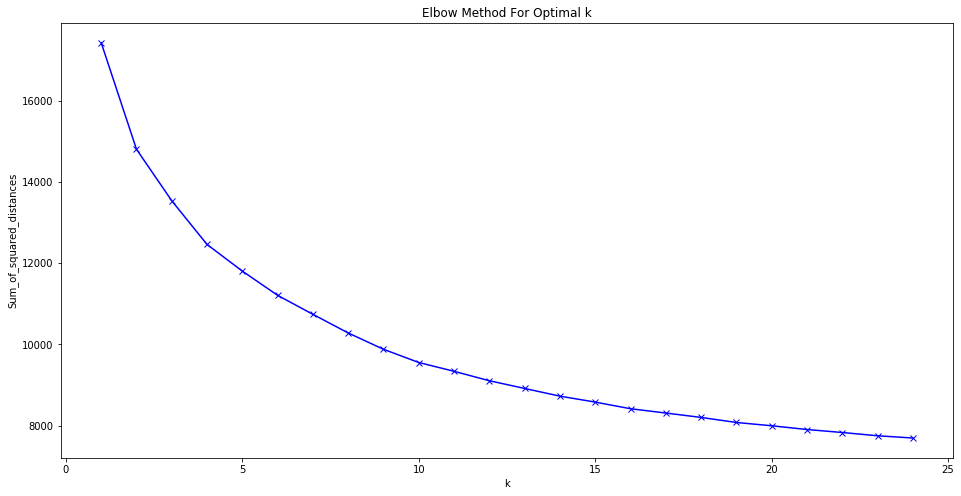

In [23]:
Sum_of_squared_distances = [KMeans(n_clusters=k).fit(similarities_distances).inertia_ for k in range(1,25)]

plt.figure(figsize=(16,8))
plt.plot(range(1,25), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

__comments__ : The elbow method does not show an obvious optimal k. This is usually the case in clustering with Natural language processing. The best k and best clusters are found by trying many computations and checking the composition of each clutser. In this case, k=10 turns out to give good results.

In [23]:
# Fitting K-Means to the dataset
cluster_number = 10
kmeans_ = KMeans(n_clusters = cluster_number, init = 'k-means++', random_state = 0)
%time kmeans_.fit(similarities_distances)

clusters_ = kmeans_.labels_
#centers_ = kmeans_.cluster_centers_
print(Counter(clusters_))

Wall time: 3.4 s
Counter({2: 194, 3: 191, 0: 161, 8: 156, 1: 147, 4: 123, 5: 111, 7: 105, 6: 72, 9: 40})


In [24]:
clusters_composition = {}
for k in range(0, cluster_number):
    clusters_composition[k] = unique_categories[clusters_==k]
    
    words = []
    for i in clusters_composition[k]: 
        v = i.split(' ')
        for vv in v:
            if vv != '':
                words.append(vv)
    print('Most common words in cluster '+ str(k) +':')
    print(Counter(words).most_common(20))
    print('--------------------')

Most common words in cluster 0:
[('repair', 28), ('rental', 15), ('equipment', 14), ('installation', 14), ('car', 12), ('rentals', 11), ('dealers', 10), ('home', 9), ('auto', 8), ('cleaning', 7), ('supplies', 7), ('bike', 7), ('furniture', 5), ('mobile', 5), ('truck', 4), ('motorcycle', 4), ('tours', 3), ('services', 3), ('gear', 3), ('boat', 3)]
--------------------
Most common words in cluster 1:
[('bars', 17), ('food', 12), ('beer', 6), ('wine', 5), ('tea', 4), ('tasting', 4), ('bar', 3), ('classes', 3), ('coffee', 3), ('pub', 3), ('breakfast', 2), ('tours', 2), ('chicken', 2), ('markets', 2), ('sushi', 2), ('hot', 2), ('seafood', 2), ('tapas', 2), ('acai', 1), ('bowls', 1)]
--------------------
Most common words in cluster 2:
[('law', 17), ('estate', 6), ('home', 5), ('printing', 4), ('real', 4), ('agents', 3), ('houses', 3), ('loans', 3), ('planning', 3), ('design', 3), ('airport', 2), ('architects', 2), ('brokers', 2), ('family', 2), ('center', 2), ('environmental', 2), ('testing

__comments__ : Some clusters are better defined and give a better human-sight understanding of a business type. What we need to keep in mind is that clients won't have the same behaviour and type of complain depending on the product or service the business sell. 
   - Cluster 0 is about transportation services
   - Cluster 1 is all about food and drinks (bars or restaurants)
   - Cluster 3 is about social activities
   - Cluster 4 is about healthcare
   - Cluster 6 does not describe a type of business but nationnalities that Yelp precises as a category
   - Cluster 7 is about shops and stores
   - Cluster 8 is about Life places

whereas cluster 2, 5 and 9 are a bit less obvious.

In [25]:
#drag business to the group they belong the most
result_clusters = []
for b in business.categories.values:
    all_cat_company = b.split(',') 

    cluster_belong = -1* np.ones(len(all_cat_company))

    for index, single_cat in enumerate(all_cat_company):
        single_cat = single_cat.replace('&', '').replace('/', ' ').lstrip().rstrip().lower()
        
        for i in range(0, cluster_number):
            if i==6:
                pass
            if single_cat in clusters_composition[i]:
                cluster_belong[index] = i
                break
            else:
                pass
        
    result_clusters.append(stats.mode(cluster_belong, axis=None)[0][0])

In [26]:
results_clusters_theme = {'food_and_drinks' : Counter(result_clusters)[1], 
                          '2' : Counter(result_clusters)[2], 
                          'social_activities' : Counter(result_clusters)[3],
                         'healthcare' : Counter(result_clusters)[4],
                         '5' : Counter(result_clusters)[5],
                         'nationnalities' : Counter(result_clusters)[6],
                         'stores_and_shops' : Counter(result_clusters)[7],
                         'life_places' : Counter(result_clusters)[8],
                         '9' : Counter(result_clusters)[9],
                         'transportation_services' : Counter(result_clusters)[0],}
pprint(results_clusters_theme)

{'2': 18892,
 '5': 11375,
 '9': 18,
 'food_and_drinks': 56496,
 'healthcare': 17092,
 'life_places': 9406,
 'nationnalities': 14042,
 'social_activities': 13333,
 'stores_and_shops': 26734,
 'transportation_services': 24739}


In [27]:
# add cluster feature to dataframe and drop the former categories feature 
clusters_named = []
for i in result_clusters:
    if i==0:
        clusters_named.append('transportation_services')
    elif i==1:
        clusters_named.append('food_and_drinks')
    elif i==2:
        clusters_named.append('2')
    elif i==3:
        clusters_named.append('social_activities')
    elif i==4:
        clusters_named.append('healthcare')
    elif i==5:
        clusters_named.append('5')
    elif i==6:
        clusters_named.append('nationnalities')
    elif i==7:
        clusters_named.append('stores_and_shops')
    elif i==8:
        clusters_named.append('life_places')
    else :
        clusters_named.append('9')
business['cluster'] = clusters_named
business = business.drop(['categories'], axis=1)

In [28]:
business.head(4)

business_id                             name           state  \
0  1SWheh84yJXfytovILXOAQ       Arizona Biltmore Golf Club         arizona   
1  QXAEGFB4oINsVuTFxEYKFQ       Emerald Chinese Restaurant         ontario   
2  gnKjwL_1w79qoiV3IC_xQQ      Musashi Japanese Restaurant  north_carolina   
3  xvX2CttrVhyG2z1dFg_0xw  Farmers Insurance - Paul Lorenz         arizona   

    latitude   longitude  stars  review_count  is_open  \
0  33.522143 -112.018481    3.0             5        0   
1  43.605499  -79.652289    2.5           128        1   
2  35.092564  -80.859132    4.0           170        1   
3  33.455613 -112.395596    5.0             3        1   

                                          attributes  ratio_stars_review  \
0                           {'GoodForKids': 'False'}            0.600000   
1  {'RestaurantsReservations': 'True', 'GoodForMe...            0.019531   
2  {'GoodForKids': 'True', 'NoiseLevel': 'u'avera...            0.023529   
3                                               None            1.666667   

           cluster  
0                2  
1  food_and_drinks  
2  food_and_drinks  
3                2

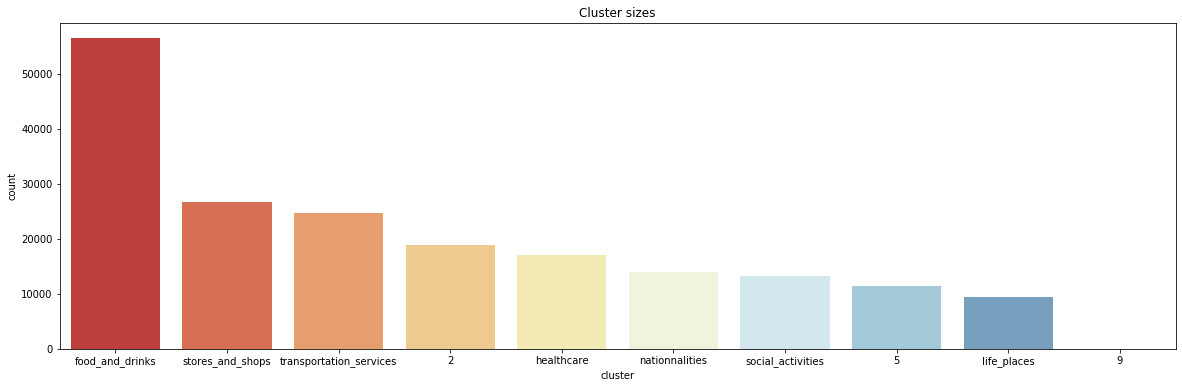

In [29]:
plt.figure(figsize=(20,6))
plt.title('Cluster sizes')
sns.countplot(x='cluster', data=business, order = business['cluster'].value_counts().index, palette='RdYlBu')
plt.show()

__comments__: Using a clustering on this feature was really useful. The 1300 unique categories where changed into 10. From the bar plot above, we clearly see that Yelp is mostly used for restaurants and bars. 

## 2.3 Understand Yelp activity

Since we know there are different types of businesses, we need to know more about Yelp behaviour against those types of businesses and against spatial locations.

### 2.3.1 Overall statistics

In [30]:
y2 = business.groupby('state').size().values
y3 = business.groupby(['state'])['review_count'].sum().values
index = business.groupby('state').size().keys()

y4 = (y3/y3.sum())*100
y5 = (y2/y2.sum())*100

y6 =  business.groupby(['state'])['stars'].mean()
y7 = business.groupby(['state'])['stars'].std()

y8 = business.groupby(['state'])['ratio_stars_review'].std()

y9 = business.groupby(['state'])['ratio_stars_review'].mean()

business_statistics = pd.DataFrame({'nb_of_business': y2,
                                  'nb_of_business_in_perc': y5,
                                  'nb_of_reviews': y3, 
                                  'nb_of_reviews_in_perc': y4,
                                  'stars_mean' : y6,
                                  'ratio_stars_review_mean' : y9,
                                  'stars_std' : y7,
                                  'ratio_stars_review_std' : y8,
                                  'state': index}, index=index)

In [31]:
business_statistics

nb_of_business  nb_of_business_in_perc  nb_of_reviews  \
state                                                                   
DOW                          1                0.000520              4   
DUR                          1                0.000520              3   
XGL                          1                0.000520              3   
XWY                          2                0.001041              8   
alabama                      3                0.001561             12   
alaska                       2                0.001041              7   
alberta                   7998                4.162871          96716   
arizona                  56520               29.418041        2002368   
arkansas                     1                0.000520              7   
california                  19                0.009889            247   
connecticut                  3                0.001561             16   
florida                      4                0.002082            698   
georgia                      2                0.001041             14   
illinois                  1927                1.002982          40998   
nebraska                     2                0.001041             12   
nevada                   36213               18.848470        2243119   
new_jersey                   1                0.000520              8   
new_mexico                   1                0.000520             14   
new_york                    22                0.011451            273   
north_carolina           14684                7.642861         394170   
ohio                     14665                7.632972         310409   
ontario                  33344               17.355187         760865   
pennsylvania             11197                5.827916         281049   
quebec                    9189                4.782774         175630   
south_carolina            1159                0.603247          20453   
tennessee                    1                0.000520              3   
texas                        6                0.003123           1052   
utah                         1                0.000520              4   
vermont                      2                0.001041              8   
virginia                     2                0.001041             16   
washington                   3                0.001561             18   
wisconsin                 5151                2.681039         129595   

                nb_of_reviews_in_perc  stars_mean  ratio_stars_review_mean  \
state                                                                        
DOW                          0.000062    3.000000                 0.750000   
DUR                          0.000046    3.500000                 1.166667   
XGL                          0.000046    4.500000                 1.500000   
XWY                          0.000124    4.500000                 1.200000   
alabama                      0.000186    3.833333                 0.972222   
alaska                       0.000108    2.750000                 0.750000   
alberta                      1.497662    3.386659                 0.626800   
arizona                     31.006973    3.711978                 0.484271   
arkansas                     0.000108    2.000000                 0.285714   
california                   0.003825    4.026316                 0.496825   
connecticut                  0.000248    3.500000                 0.731481   
florida                      0.010809    2.500000                 0.224480   
georgia                      0.000217    3.750000                 0.946970   
illinois                     0.634860    3.468085                 0.515993   
nebraska                     0.000186    3.000000                 0.625000   
nevada                      34.735039    3.700660                 0.422075   
new_jersey                   0.000124    5.000000                 0.625000   
new_mexico                   0.000217    2.500000  

__comments__ : Data are not evenly distributed depending on the state, especially regarding the number of business or number of reviews per state. It goes from a really low number to a high one: 1 business that signed up in Tenessee for example to more than 50 000 in Arizona. 

In [32]:
# Thus we drop the states where nb_of_reviews is too low because we need to compare even distribution later on 
states_to_drop = business_statistics[(business_statistics.nb_of_reviews<=20) ].index.values
print('states to drop because the number of restaurants is too low (1 or 2)')
print(states_to_drop)

business = business[~business['state'].isin(states_to_drop) ]
business_statistics = business_statistics[~business_statistics['state'].isin(states_to_drop)]

states to drop because the number of restaurants is too low (1 or 2)
['DOW' 'DUR' 'XGL' 'XWY' 'alabama' 'alaska' 'arkansas' 'connecticut'
 'georgia' 'nebraska' 'new_jersey' 'new_mexico' 'tennessee' 'utah'
 'vermont' 'virginia' 'washington']


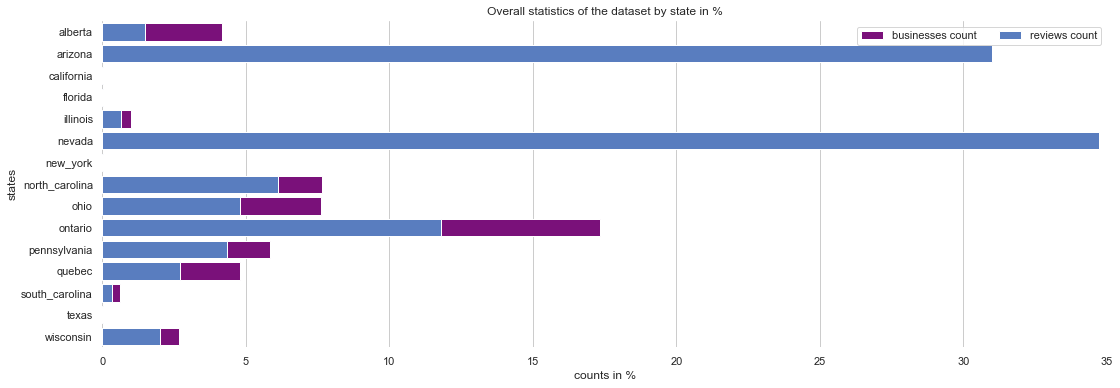

In [33]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(18, 6))
sns.set_color_codes("muted")
sns.barplot(x="nb_of_business_in_perc", y="state", data=business_statistics,
            label="businesses count", color="darkmagenta")

sns.set_color_codes("muted")
sns.barplot(x="nb_of_reviews_in_perc", y="state", data=business_statistics,
            label="reviews count", color="b")

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, 35), ylabel="states", xlabel="counts in %", title="Overall statistics of the dataset by state in %")
sns.despine(left=True, bottom=True)

__comments__ : 
   - On the customer side: Yelp is a platform widely used in Arizona, nevada and ontario based on the number of reviews per state. 
   - On the other side and based on the percentage of number of restaurants in the platform, it is also used in Ontario, Quebec, ALberta. 

### 2.3.2 Distribution of the ratio stars per reviews

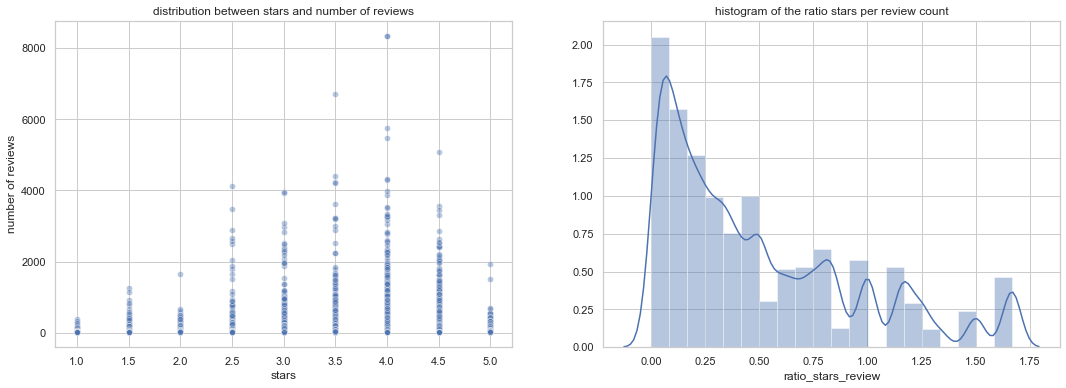

In [34]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.scatterplot(x='stars', y='review_count', data=business, alpha=0.4)
plt.title('distribution between stars and number of reviews')
plt.ylabel('number of reviews')
plt.xlabel('stars')

plt.subplot(1,2,2)
sns.distplot(business['ratio_stars_review'], bins=20)
plt.title('histogram of the ratio stars per review count')

plt.show()

__comments__: Overall star is probably already the average of all the stars given by each client. Hence, it's natural that the highest number of reviews tends to an average of stars. Considering the scale of the number of review versus the star, the distribution of the ratio is highly right skewed, with a mean close to 0 as 1/n tends to 0 when n tends to infinity. However, we can notice some outliers in each category in both figures and the distribution is clearly fat tailed.
Thoses outliers would mean either that the number of reviews is abnormaly high and there is a consensus within users (left figure) or either a really low number of reviews (right figure).

### 2.3.3 Does the ratio stars per reviews depend on the state and type of business ?

In [35]:
business_theme = business.copy()
business_theme = business_theme[business_theme.cluster != '5']
business_theme = business_theme[business_theme.cluster != '2']
business_theme = business_theme[business_theme.cluster != '9']
business_theme = business_theme[business_theme.cluster != 'nationnalities']

__The ratio regarding the states__

<Figure size 1296x360 with 0 Axes>

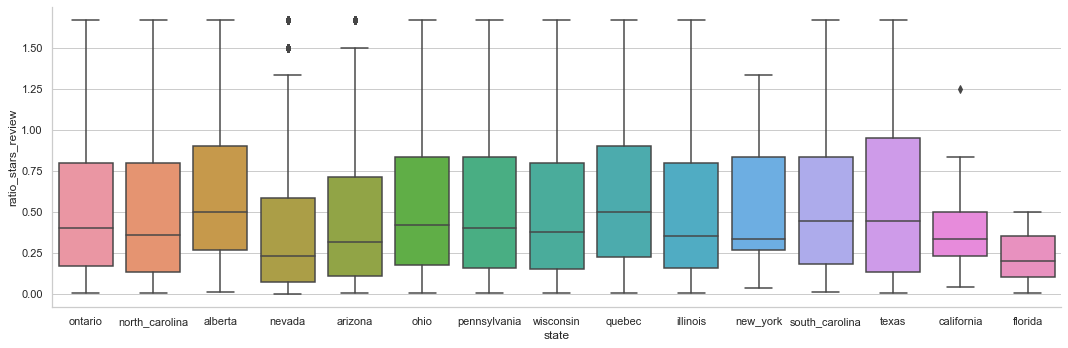

In [36]:
plt.figure(figsize=(18,5))
sns.catplot(x="state", y="ratio_stars_review", kind="box", data=business_theme, height=5, aspect=3)
plt.show()

__comments__: There is no significant differences between states within the whole dataset considering each state does not have the same number of businesses registered.

__The ratio regarding the types__

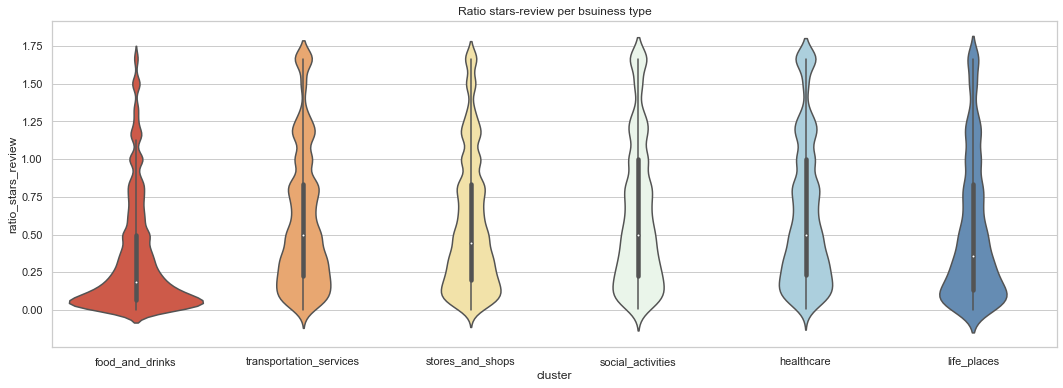

In [37]:
plt.figure(figsize=(18,6))
sns.violinplot(x="cluster", y="ratio_stars_review", data=business_theme, palette='RdYlBu')
plt.title('Ratio stars-review per bsuiness type')
plt.show()

__comments__ : 
The ratio score per number of reviews depends much more on the type of business rather than the state. Food and drinks type has a siginificant different shape compared to other types. It also has the lowest mean and a lot of outliers.

__The ratio regarding the states in the food and drinks type__

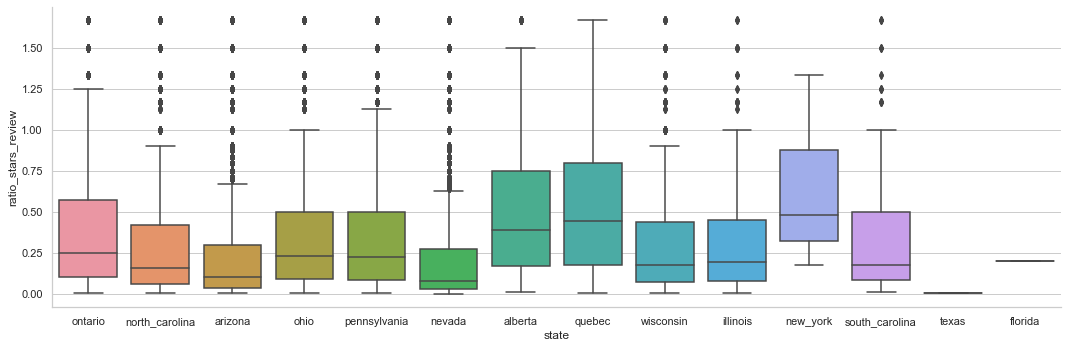

In [38]:
sns.catplot(x="state", y="ratio_stars_review", kind="box", data=business_theme[(business_theme.cluster == 'food_and_drinks')], height=5, aspect=3)
plt.show()

__comments__: This is an interesting output. Filtered by 'food and drinks' type of business, there is a significant change betweeen states. This was not seen in the whole dataset.
We can still notice a slight difference between states nevada and arizona seems to have outliers and a low mean. Arizona and nevada have the lowest mean and the highest number of outliers.

---
These findings are however tricky since the ratio stars/reviews will mostly have a different shape because of the number of reviews. Hence in the following part, we will compare these first insights to the ratio of closed restaurants 

### 2.3.4 Ratio of closed restaurants 

In this section we want to see if there is a primary link between the number of closed restaurants/bars and the yelp activity according to a given score and number of reviews. To do so, we will check the centrality and the dispersion versus this ratio. The box plot above showed that many outliers were found so robust metrics against outliers are computed: the median instead of the mean and the inter quartile range instead of the standard deviation.

In [39]:
food_and_drinks = business[business.cluster=='food_and_drinks']
counts_ = food_and_drinks.groupby(['state', 'is_open']).size()

states_to_plot = list(np.unique(food_and_drinks.state.values))
states_to_plot.remove('florida')
states_to_plot.remove('texas') #
states_to_plot.remove('new_york') #only 1

ratio_close = []
median_ratio_stars_review = []
iqr_ratio_stars_review = []

for state in states_to_plot:
    ratio_close.append(100 * counts_[state][0] / (counts_[state][0] + counts_[state][1]))
    median_ratio_stars_review.append(food_and_drinks[food_and_drinks.state == state]['ratio_stars_review'].median())
    iqr = food_and_drinks[food_and_drinks.state == state]['ratio_stars_review'].quantile(0.75) - food_and_drinks[food_and_drinks.state == state]['ratio_stars_review'].quantile(0.25) 
    iqr_ratio_stars_review.append(iqr)

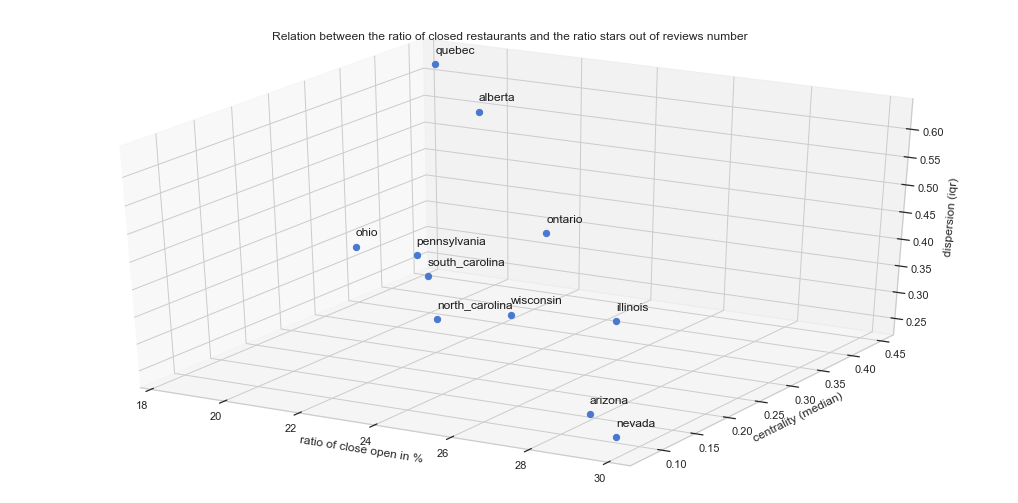

In [40]:
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(111, projection='3d')

for i, txt in enumerate(states_to_plot): # plot each point + it's index as text above
    label = txt
    ax.scatter(ratio_close[i], median_ratio_stars_review[i], iqr_ratio_stars_review[i], color='b', s=40)
    ax.text(ratio_close[i], median_ratio_stars_review[i], iqr_ratio_stars_review[i] + 0.02, '%s' % (label), size=12, zorder=1, color='k')

ax.set_xlabel('ratio of close open in %')
ax.set_ylabel('centrality (median)')
ax.set_zlabel('dispersion (iqr)')
ax.set_title('Relation between the ratio of closed restaurants and the ratio stars out of reviews number')
plt.show()

__comments__ : 
    The states that have the highest ratio of closed restaurants in Yelp dataset (around 28%) are those that have the lowest median of the ratio stars/reviews and among the lowest iqr. Thus, this figure highlights that there might be a link between those 2 variables. The further research is done with the arizona case.

# 3. The restaurants and bars in Arizona study case

## 3.1 Data preprocessing

### 3.1.1 Cutting business dataframe to arizona case and food_and_drinks cluster

In [41]:
arizona_food_and_drinks = business[business.state=='arizona']
arizona_food_and_drinks = arizona_food_and_drinks[arizona_food_and_drinks.cluster=='food_and_drinks']

In [42]:
arizona_food_and_drinks.head(3)

business_id                      name    state   latitude  \
11  1Dfx3zM-rW4n-31KeC8sJg                 Taco Bell  arizona  33.495194   
47  GWO87Y-IqL54_Ijx6hTYAQ  Bruster's Real Ice Cream  arizona  33.320386   
53  q2KtxnPa6rPSpAlMbg9l8g       Nothing Bundt Cakes  arizona  33.640308   

     longitude  stars  review_count  is_open  \
11 -112.028588    3.0            18        1   
47 -111.804652    4.5            57        0   
53 -111.924528    4.0           174        1   

                                           attributes  ratio_stars_review  \
11  {'RestaurantsTakeOut': 'True', 'BusinessParkin...            0.166667   
47  {'BusinessAcceptsCreditCards': 'True', 'BikePa...            0.078947   
53  {'BikeParking': 'True', 'BusinessParking': '{'...            0.022989   

            cluster  
11  food_and_drinks  
47  food_and_drinks  
53  food_and_drinks

In [43]:
# we don't need the information about state and cluster in the first dataframe 
arizona_food_and_drinks = arizona_food_and_drinks.drop(['state', 'cluster'], axis=1)

In [44]:
arizona_food_and_drinks.isnull().sum()

business_id             0
name                    0
latitude                0
longitude               0
stars                   0
review_count            0
is_open                 0
attributes            339
ratio_stars_review      0
dtype: int64

### 3.1.2 Reviews

In [45]:
review_arizona.head(3)

business_id  cool                date  funny  \
0  zvO-PJCpNk4fgAVUnExYAA     1 2010-10-05 19:12:35      1   
1  mRUVMJkUGxrByzMQ2MuOpA     0 2017-12-15 23:27:08      1   
2  cHdJXLlKNWixBXpDwEGb_A     1 2015-04-01 16:30:00      7   

                review_id  stars  \
0  8e9HxxLjjqc9ez5ezzN7iQ      1   
1  -I5umRTkhw15RqpKMl_o1Q      1   
2  6BnQwlxRn7ZuWdzninM9sQ      3   

                                                text  useful  \
0  This place has gone down hill.  Clearly they h...       3   
1  Walked in around 4 on a Friday afternoon, we s...       0   
2  I love chinese food and I love mexican food. W...       1   

                  user_id  
0  d6xvYpyzcfbF_AZ8vMB7QA  
1  -mA3-1mN4JIEkqOtdbNXCQ  
2  JSrP-dUmLlwZiI7Dp3PQ2A

In [46]:
#check if there is any missing values
review_arizona.isnull().sum()

business_id    0
cool           0
date           0
funny          0
review_id      0
stars          0
text           0
useful         0
user_id        0
dtype: int64

In [47]:
#check if there is any review duplicates 
review_arizona[review_arizona.duplicated(['review_id'])]

Empty DataFrame
Columns: [business_id, cool, date, funny, review_id, stars, text, useful, user_id]
Index: []

### 3.1.3 Merging

In [48]:
arizona_case = arizona_food_and_drinks.merge(review_arizona, left_on='business_id', right_on='business_id').set_index(['business_id'], drop=False).sort_index()
arizona_case['overall_star'] = arizona_case.stars_x
arizona_case['single_client_star'] = arizona_case.stars_y
arizona_case = arizona_case.drop(['stars_x', 'stars_y'], axis=1)

In [49]:
arizona_case.head(2)

business_id      name   latitude  \
business_id                                                           
--Rsj71PBe31h5YljVseKA  --Rsj71PBe31h5YljVseKA  Circle K  33.713424   
--Rsj71PBe31h5YljVseKA  --Rsj71PBe31h5YljVseKA  Circle K  33.713424   

                         longitude  review_count  is_open  \
business_id                                                 
--Rsj71PBe31h5YljVseKA -112.099279             9        1   
--Rsj71PBe31h5YljVseKA -112.099279             9        1   

                                                               attributes  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA  {'OutdoorSeating': 'False', 'RestaurantsTakeOu...   
--Rsj71PBe31h5YljVseKA  {'OutdoorSeating': 'False', 'RestaurantsTakeOu...   

                        ratio_stars_review  cool                date  funny  \
business_id                                                                   
--Rsj71PBe31h5YljVseKA            0.388889     0 2017-11-16 23:20:36      0   
--Rsj71PBe31h5YljVseKA            0.388889     0 2016-10-30 03:31:25      0   

                                     review_id  \
business_id                                      
--Rsj71PBe31h5YljVseKA  lAreRgokYmhprSC99VQlcA   
--Rsj71PBe31h5YljVseKA  xdWHHJZIIUIQfuGRzIRaPQ   

                                                                     text  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA  This Circle K store was clean and well run whe...   
--Rsj71PBe31h5YljVseKA  We love this store. We will always drive out o...   

                        useful                 user_id  overall_star  \
business_id                                                            
--Rsj71PBe31h5YljVseKA       0  813qGlE2OI7oy8yhd2K4rg           3.5   
--Rsj71PBe31h5YljVseKA       0  _O4k9mJHTOfKat2lhaQVpQ           3.5   

                        single_client_star  
business_id                                 
--Rsj71PBe31h5YljVseKA                   1  
--Rsj71PBe31h5YljVseKA                   5

In [50]:
print('unique business id: ', arizona_case.index.unique().shape[0])
print('number total of reviews: ', arizona_case.review_id.count())

unique business id:  10631
number total of reviews:  997457


In [51]:
arizona_case.isnull().sum()

business_id              0
name                     0
latitude                 0
longitude                0
review_count             0
is_open                  0
attributes            3073
ratio_stars_review       0
cool                     0
date                     0
funny                    0
review_id                0
text                     0
useful                   0
user_id                  0
overall_star             0
single_client_star       0
dtype: int64

__comment__ : From now on, single star rating, time of reviewing and content of reviews are available. The features useful, funny and cool are the number of votes received by other users graded as useful, funny or cool.

In [52]:
#we save in one separate dataframe the business information for an easier using
arizona_case_business_info = arizona_case.drop_duplicates(subset=['business_id'], inplace=False).set_index(['business_id']).sort_index()
arizona_case_business_info = arizona_case_business_info.drop(['cool', 'date', 'funny', 'review_id', 'text', 'useful', 'user_id', 'single_client_star'], axis=1)

In [53]:
arizona_case_business_info.head(3)

name   latitude   longitude  \
business_id                                                           
--Rsj71PBe31h5YljVseKA              Circle K  33.713424 -112.099279   
-01XupAWZEXbdNbxNg5mEg            18 Degrees  33.639205 -111.881925   
-050d_XIor1NpCuWkbIVaQ  Matt's Big Breakfast  33.456696 -112.072327   

                        review_count  is_open  \
business_id                                     
--Rsj71PBe31h5YljVseKA             9        1   
-01XupAWZEXbdNbxNg5mEg            99        1   
-050d_XIor1NpCuWkbIVaQ           703        0   

                                                               attributes  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA  {'OutdoorSeating': 'False', 'RestaurantsTakeOu...   
-01XupAWZEXbdNbxNg5mEg  {'RestaurantsGoodForGroups': 'True', 'Music': ...   
-050d_XIor1NpCuWkbIVaQ  {'Corkage': 'False', 'RestaurantsReservations'...   

                        ratio_stars_review  overall_star  
business_id                                               
--Rsj71PBe31h5YljVseKA            0.388889           3.5  
-01XupAWZEXbdNbxNg5mEg            0.030303           3.0  
-050d_XIor1NpCuWkbIVaQ            0.005690           4.0

__comments__: great now we have all the information needed, sorted by business_id

## 3.2 A deeper analysis on features


### 3.2.1 Yelp overall star : a true average computation? 

In this part, we want to check how is computed the overall grade of a business and the effects on this computation to other variables.

__adding info about the star rating behaviour of each business__

In [54]:
#true mean from each star given by client per business id
arizona_case_business_info['true_mean_stars'] = arizona_case.groupby(arizona_case.index)['single_client_star'].mean() 
#true std from each star given by client per business id
arizona_case_business_info['true_std_stars'] = arizona_case.groupby(arizona_case.index)['single_client_star'].std() 
#true median from each star given by client per business id
arizona_case_business_info['true_median_stars'] = arizona_case.groupby(arizona_case.index)['single_client_star'].median() 
#true inter quantile range
arizona_case_business_info['true_iqr_stars'] = arizona_case.groupby(arizona_case.index)['single_client_star'].quantile(0.75) - arizona_case.groupby(arizona_case.index)['single_client_star'].quantile(0.25)

__computing the difference between the true mean and the final Yelp output__

In [55]:
yelp_output = arizona_case_business_info['overall_star']
mean_stars = arizona_case_business_info['true_mean_stars']
acceptable_output = np.unique(yelp_output) #yelp range its overall final star between 1 and 5 with a step of 0.5
rounded_mean_stars = []

for number in mean_stars:
    rounded_number = acceptable_output.flat[np.abs(acceptable_output - number).argmin()]
    rounded_mean_stars.append(rounded_number)

arizona_case_business_info['rounded_mean_stars'] = rounded_mean_stars
arizona_case_business_info['difference_of_output_star'] = arizona_case_business_info['overall_star'] - arizona_case_business_info['rounded_mean_stars']

__results__

In [56]:
arizona_case_business_info.head()

name   latitude   longitude  \
business_id                                                           
--Rsj71PBe31h5YljVseKA              Circle K  33.713424 -112.099279   
-01XupAWZEXbdNbxNg5mEg            18 Degrees  33.639205 -111.881925   
-050d_XIor1NpCuWkbIVaQ  Matt's Big Breakfast  33.456696 -112.072327   
-0Sgh0QlUKVsWosCWJzGqQ        Domino's Pizza  33.414346 -111.928995   
-0WegMt6Cy966qlDKhu6jA      Game Seven Grill  33.445595 -112.068470   

                        review_count  is_open  \
business_id                                     
--Rsj71PBe31h5YljVseKA             9        1   
-01XupAWZEXbdNbxNg5mEg            99        1   
-050d_XIor1NpCuWkbIVaQ           703        0   
-0Sgh0QlUKVsWosCWJzGqQ            47        1   
-0WegMt6Cy966qlDKhu6jA           100        1   

                                                               attributes  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA  {'OutdoorSeating': 'False', 'RestaurantsTakeOu...   
-01XupAWZEXbdNbxNg5mEg  {'RestaurantsGoodForGroups': 'True', 'Music': ...   
-050d_XIor1NpCuWkbIVaQ  {'Corkage': 'False', 'RestaurantsReservations'...   
-0Sgh0QlUKVsWosCWJzGqQ  {'GoodForKids': 'True', 'BusinessAcceptsCredit...   
-0WegMt6Cy966qlDKhu6jA  {'Caters': 'False', 'BikeParking': 'True', 'Am...   

                        ratio_stars_review  overall_star  true_mean_stars  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA            0.388889           3.5         3.200000   
-01XupAWZEXbdNbxNg5mEg            0.030303           3.0         3.067961   
-050d_XIor1NpCuWkbIVaQ            0.005690           4.0         3.995862   
-0Sgh0QlUKVsWosCWJzGqQ            0.042553           2.0         1.979592   
-0WegMt6Cy966qlDKhu6jA            0.020000           2.0         2.039216   

                        true_std_stars  true_median_stars  true_iqr_stars  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA        1.751190                4.0             3.5   
-01XupAWZEXbdNbxNg5mEg        1.450234                3.0             2.0   
-050d_XIor1NpCuWkbIVaQ        1.111832                4.0             2.0   
-0Sgh0QlUKVsWosCWJzGqQ        1.391788                1.0             2.0   
-0WegMt6Cy966qlDKhu6jA        1.159733                2.0             2.0   

                        rounded_mean_stars  difference_of_output_star  
business_id                                                            
--Rsj71PBe31h5YljVseKA                 3.0                        0.5  
-01XupAWZEXbdNbxNg5mEg                 3.0                        0.0  
-050d_XIor1NpCuWkbIVaQ                 4.0                        0.0  
-0Sgh0QlUKVsWosCWJzGqQ                 2.0                        0.0  
-0WegMt6Cy966qlDKhu6jA                 2.0                        0.0

In [57]:
ratio_outliers_up_down = {
    '+0.5' : 100* Counter(yelp_output - rounded_mean_stars)[0.5]/len(yelp_output),
    '-0.5' : 100* Counter(yelp_output - rounded_mean_stars)[-0.5]/len(yelp_output),
    '-1.0' : 100* Counter(yelp_output - rounded_mean_stars)[-1.0]/len(yelp_output),
    '+1.0' : 100* Counter(yelp_output - rounded_mean_stars)[1.0]/len(yelp_output),
    '+1.5' : 100* Counter(yelp_output - rounded_mean_stars)[1.5]/len(yelp_output),
}

print('number of up and down rating vs the true rounded average')
print(Counter(yelp_output - rounded_mean_stars))

print('---------------------------------------------------------------')

print('ratio_outliers_up_down')
print(ratio_outliers_up_down)

print('---------------------------------------------------------------')

print('count_outliers_up_down_ for opened')
print(Counter(arizona_case_business_info[arizona_case_business_info.is_open==1]['difference_of_output_star']))
print()
print('count_outliers_up_down_ for close')
print(Counter(arizona_case_business_info[arizona_case_business_info.is_open==0]['difference_of_output_star']))

print('---------------------------------------------------------------')
print('The restaurants that got -1.0 point in their overall star score are:')
print(arizona_case_business_info[arizona_case_business_info.difference_of_output_star==-1.0][['name', 'overall_star', 'rounded_mean_stars']])

print('---------------------------------------------------------------')
print('The restaurants that got +1.0 point in their overall star score are:')
print(arizona_case_business_info[arizona_case_business_info.difference_of_output_star==1.0][['name', 'overall_star', 'rounded_mean_stars']])

print('---------------------------------------------------------------')
print('The restaurants that got +1.5 point in their overall star score are:')
print(arizona_case_business_info[arizona_case_business_info.difference_of_output_star==1.5][['name', 'overall_star', 'rounded_mean_stars']])

number of up and down rating vs the true rounded average
Counter({0.0: 10000, 0.5: 400, -0.5: 226, -1.0: 2, 1.0: 2, 1.5: 1})
---------------------------------------------------------------
ratio_outliers_up_down
{'+0.5': 3.76258113065563, '-0.5': 2.125858338820431, '-1.0': 0.018812905653278148, '+1.0': 0.018812905653278148, '+1.5': 0.009406452826639074}
---------------------------------------------------------------
count_outliers_up_down_ for opened
Counter({0.0: 7221, 0.5: 269, -0.5: 135, 1.0: 1})

count_outliers_up_down_ for close
Counter({0.0: 2779, 0.5: 131, -0.5: 91, -1.0: 2, 1.0: 1, 1.5: 1})
---------------------------------------------------------------
The restaurants that got -1.0 point in their overall star score are:
                                             name  overall_star  \
business_id                                                       
656XUeBmMzyvU62yYHptxQ  Long Wong's North Phoenix           2.0   
CFortoBLONVZ8YF-nY5H3A  Cathy's Rum Cake Catering           

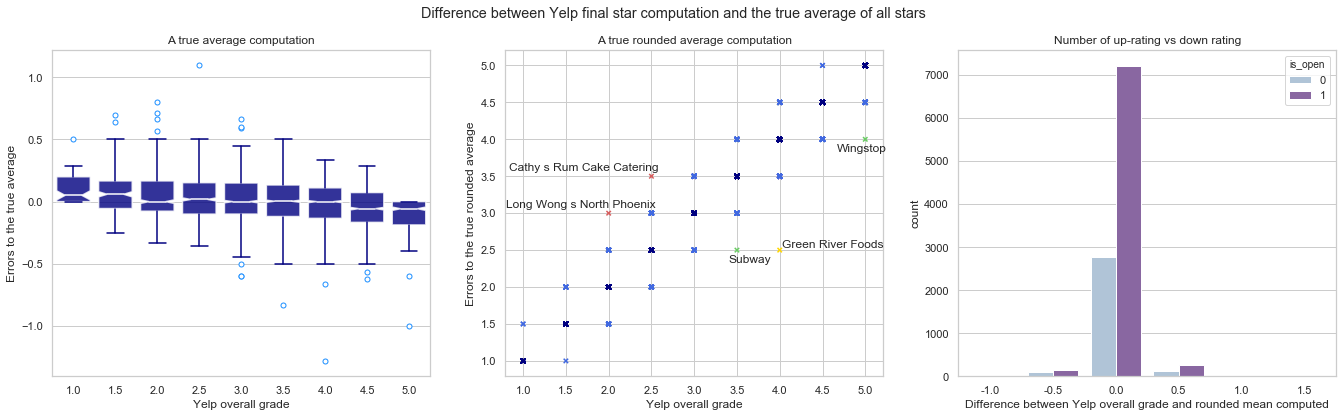

In [58]:
plt.figure(figsize=(23, 6))

plt.subplot(1,3,1)
sns.boxplot(x=yelp_output, y=mean_stars - yelp_output, notch=True, 
            boxprops={'alpha':.8, 'edgecolor':'white', 'facecolor':'navy'},
            whiskerprops={'color':'navy'},
            medianprops={'color':'white'},
            flierprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'dodgerblue'},
            capprops={'color':'navy'})
plt.xlabel('Yelp overall grade')
plt.ylabel('Errors to the true average')
plt.title('A true average computation')

plt.subplot(1,3,2)
colors = np.where(yelp_output==rounded_mean_stars, 'navy', 'royalblue')
colors[1225] = 'r'
colors[2275] = 'r'
colors[6865] = 'g'
colors[8901] = 'g'
colors[7961] = 'gold'
plt.scatter(x=yelp_output, y=rounded_mean_stars, s=20, c = colors, marker='x')
plt.annotate('Long Wong s North Phoenix', (2.0 - 1.2, 3.0 + .07)) #-1
plt.annotate('Cathy s Rum Cake Catering', (2.5 - 1.66, 3.5 + .07)) #-1
plt.annotate('Subway', (3.5 - .1 , 2.5 - .17)) #+1
plt.annotate('Wingstop', (5.0 - .33, 4.0 - .17)) #+1
plt.annotate('Green River Foods', (4.0 +.03, 2.5 +.03)) #+1.5
    
plt.xlabel('Yelp overall grade')
plt.ylabel('Errors to the true rounded average')
plt.title('A true rounded average computation')

plt.subplot(1,3,3)
sns.countplot(x='difference_of_output_star', data=arizona_case_business_info, hue='is_open', palette='BuPu')
plt.xlabel('Difference between Yelp overall grade and rounded mean computed')
plt.title('Number of up-rating vs down rating')

plt.suptitle('Difference between Yelp final star computation and the true average of all stars')
plt.show()

__comments__ : Most of final Yelp star per business are computed from a true average. 3.7% of the dataset got +0.5 points more in their final compution and 2% got -0.5 points less. For those who got abnormaly lucky or unlucky, the error went up to +1.5 points and down to -1. Regarding a potential leading to the closing, there is no obvious link so far but we investigate a bit more in the following section.

__Is there an impact of this difference?__

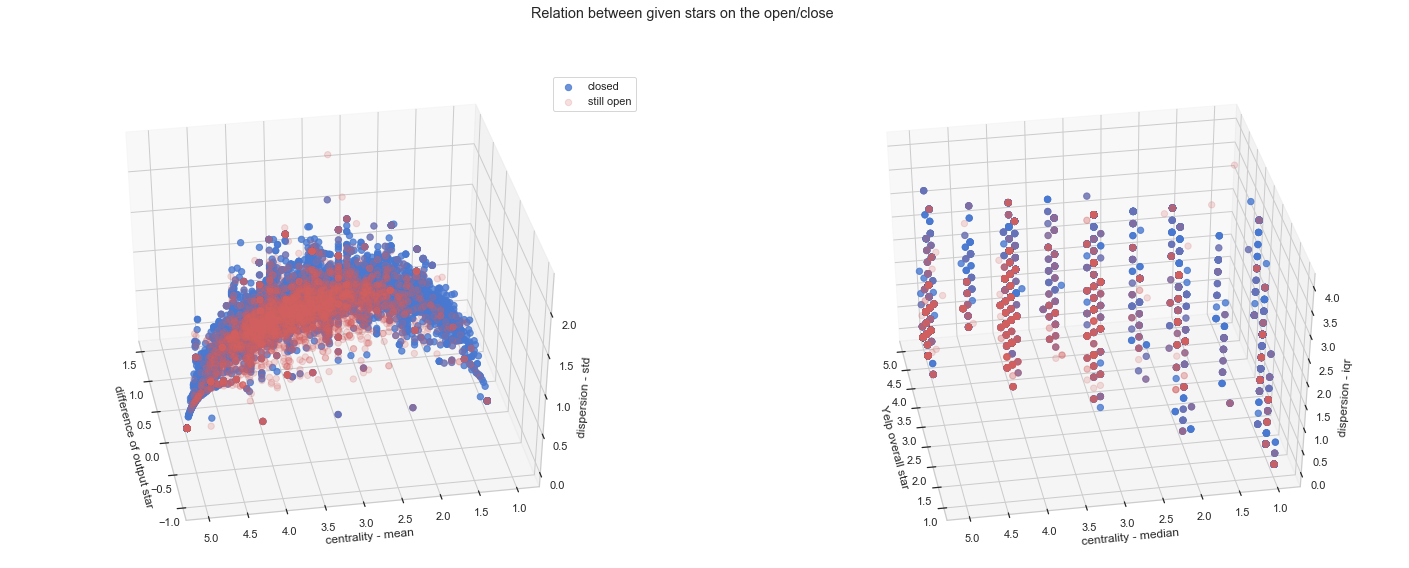

In [59]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(25,9))

ax = fig.add_subplot(1, 2, 1, projection='3d')
still_open = arizona_case_business_info.is_open==1
ax.scatter(arizona_case_business_info[still_open].difference_of_output_star, arizona_case_business_info[still_open].true_mean_stars, arizona_case_business_info[still_open].true_std_stars, color='b', s=40, alpha=0.8)
ax.scatter(arizona_case_business_info[~still_open].difference_of_output_star, arizona_case_business_info[~still_open].true_mean_stars, arizona_case_business_info[~still_open].true_std_stars, color='r', s=40, alpha=0.2)

ax.set_zlabel('dispersion - std')
ax.set_ylabel('centrality - mean')
ax.set_xlabel('difference of output star')
ax.legend({'still open', 'closed'})
ax.view_init(40, 170)

ax = fig.add_subplot(1, 2, 2, projection='3d')
still_open = arizona_case_business_info.is_open==1
ax.scatter(arizona_case_business_info[still_open].overall_star, arizona_case_business_info[still_open].true_median_stars, arizona_case_business_info[still_open].true_iqr_stars, color='b', s=40, alpha=0.8)
ax.scatter(arizona_case_business_info[~still_open].overall_star, arizona_case_business_info[~still_open].true_median_stars, arizona_case_business_info[~still_open].true_iqr_stars, color='r', s=40, alpha=0.2)

ax.set_zlabel('dispersion - iqr')
ax.set_ylabel('centrality - median')
ax.set_xlabel('Yelp overall star')
ax.view_init(40, 170)

plt.suptitle('Relation between given stars on the open/close')
plt.show()

__comment__ : 
- The difference of output star had no clear impact of the close/open and it seemed to happen randomly regarding the true mean and true standard deviation
- Strangely those that have a higher true median from 3 to 5 happened to be closed on the dataset. A really low dispersion means a higher consensus from clients and this seems to had led to a higher proportion of closed businesses.

### 3.2.2 Reviews rating

In this part, we mainly investigate the impact of the self-rated reviews by funny, usefull or cool.

__overview__

In [60]:
arizona_case[['useful', 'cool', 'funny']].describe()

useful           cool          funny
count  997457.000000  997457.000000  997457.000000
mean        1.173993       0.609954       0.508459
std         4.958500       2.732195       3.891694
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000
75%         1.000000       0.000000       0.000000
max      1241.000000     506.000000    1290.000000

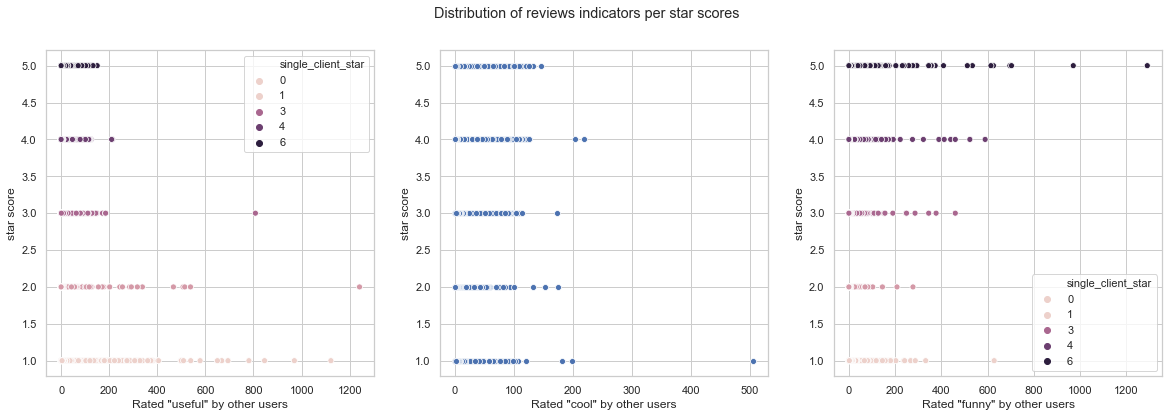

In [61]:
plt.figure(figsize=(20, 6), linewidth=5)

plt.subplot(1,3,1)
sns.scatterplot(x ='useful', y='single_client_star', data=arizona_case, hue="single_client_star", legend='brief')
plt.xlabel('Rated "useful" by other users')
plt.ylabel('star score')

plt.subplot(1,3,2)
sns.scatterplot(x ='cool', y='single_client_star', data=arizona_case)
plt.xlabel('Rated "cool" by other users')
plt.ylabel('star score')

plt.subplot(1,3,3)
sns.scatterplot(x = 'funny', y='single_client_star', data=arizona_case, hue="single_client_star", legend='brief')
plt.xlabel('Rated "funny" by other users')
plt.ylabel('star score')

plt.suptitle('Distribution of reviews indicators per star scores')
plt.show()

__comments__ : 
    That is interesting, the funny indicator has an opposite behaviour to the useful one. Indeed, it turns out that the highest rated useful by other users were for a bad star and the highest funy were for a good star. The cool score can be anything so it does not give more information.

__adding info to the database__

In [62]:
bins = [0,50,100,200,400,600]
arizona_case['useful_binned'] = np.digitize(arizona_case.useful, bins)
arizona_case['cool_binned'] = np.digitize(arizona_case.cool, bins)
arizona_case['funny_binned'] = np.digitize(arizona_case.funny, bins)

In [63]:
Counter(arizona_case['useful_binned'])

Counter({1: 996578, 2: 689, 3: 125, 4: 45, 6: 9, 5: 11})

In [64]:
test = pd.DataFrame(arizona_case.groupby([arizona_case.index, 'funny']).size())

result_mutl = pd.DataFrame({'prod_funny': np.multiply(test.index.get_level_values('funny').tolist(), test[0].values), 
                           'business_id':test.index.get_level_values('business_id').tolist()} , index=test.index.get_level_values('business_id').tolist())

result_reviews_ind = pd.DataFrame(result_mutl.groupby('business_id').sum().values.flatten(), index=result_mutl.groupby('business_id').sum().index, columns=['weighted_funny'])
result_reviews_ind['ratio_w_funny_reviews'] = result_reviews_ind['weighted_funny'] / arizona_case_business_info['review_count']

test = pd.DataFrame(arizona_case.groupby([arizona_case.index, 'cool']).size())

result_mutl = pd.DataFrame({'prod_cool': np.multiply(test.index.get_level_values('cool').tolist(), test[0].values), 
                           'business_id':test.index.get_level_values('business_id').tolist()} , index=test.index.get_level_values('business_id').tolist())

result_reviews_ind['weighted_cool'] = result_mutl.groupby('business_id').sum().values.flatten()
result_reviews_ind['ratio_w_cool_reviews'] = result_reviews_ind['weighted_cool'] / arizona_case_business_info['review_count']


test = pd.DataFrame(arizona_case.groupby([arizona_case.index, 'useful']).size())

result_mutl = pd.DataFrame({'prod_useful': np.multiply(test.index.get_level_values('useful').tolist(), test[0].values), 
                           'business_id':test.index.get_level_values('business_id').tolist()} , index=test.index.get_level_values('business_id').tolist())

result_reviews_ind['weighted_useful'] = result_mutl.groupby('business_id').sum().values.flatten()
result_reviews_ind['ratio_w_useful_reviews'] = result_reviews_ind['weighted_useful'] / arizona_case_business_info['review_count']

In [65]:
arizona_case_business_info['ratio_w_funny_reviews'] = result_reviews_ind['ratio_w_funny_reviews'] 
arizona_case_business_info['ratio_w_cool_reviews'] = result_reviews_ind['ratio_w_cool_reviews'] 
arizona_case_business_info['ratio_w_useful_reviews'] = result_reviews_ind['ratio_w_useful_reviews'] 

__results__

In [66]:
arizona_case_business_info.head()

name   latitude   longitude  \
business_id                                                           
--Rsj71PBe31h5YljVseKA              Circle K  33.713424 -112.099279   
-01XupAWZEXbdNbxNg5mEg            18 Degrees  33.639205 -111.881925   
-050d_XIor1NpCuWkbIVaQ  Matt's Big Breakfast  33.456696 -112.072327   
-0Sgh0QlUKVsWosCWJzGqQ        Domino's Pizza  33.414346 -111.928995   
-0WegMt6Cy966qlDKhu6jA      Game Seven Grill  33.445595 -112.068470   

                        review_count  is_open  \
business_id                                     
--Rsj71PBe31h5YljVseKA             9        1   
-01XupAWZEXbdNbxNg5mEg            99        1   
-050d_XIor1NpCuWkbIVaQ           703        0   
-0Sgh0QlUKVsWosCWJzGqQ            47        1   
-0WegMt6Cy966qlDKhu6jA           100        1   

                                                               attributes  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA  {'OutdoorSeating': 'False', 'RestaurantsTakeOu...   
-01XupAWZEXbdNbxNg5mEg  {'RestaurantsGoodForGroups': 'True', 'Music': ...   
-050d_XIor1NpCuWkbIVaQ  {'Corkage': 'False', 'RestaurantsReservations'...   
-0Sgh0QlUKVsWosCWJzGqQ  {'GoodForKids': 'True', 'BusinessAcceptsCredit...   
-0WegMt6Cy966qlDKhu6jA  {'Caters': 'False', 'BikeParking': 'True', 'Am...   

                        ratio_stars_review  overall_star  true_mean_stars  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA            0.388889           3.5         3.200000   
-01XupAWZEXbdNbxNg5mEg            0.030303           3.0         3.067961   
-050d_XIor1NpCuWkbIVaQ            0.005690           4.0         3.995862   
-0Sgh0QlUKVsWosCWJzGqQ            0.042553           2.0         1.979592   
-0WegMt6Cy966qlDKhu6jA            0.020000           2.0         2.039216   

                        true_std_stars  true_median_stars  true_iqr_stars  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA        1.751190                4.0             3.5   
-01XupAWZEXbdNbxNg5mEg        1.450234                3.0             2.0   
-050d_XIor1NpCuWkbIVaQ        1.111832                4.0             2.0   
-0Sgh0QlUKVsWosCWJzGqQ        1.391788                1.0             2.0   
-0WegMt6Cy966qlDKhu6jA        1.159733                2.0             2.0   

                        rounded_mean_stars  difference_of_output_star  \
business_id                                                             
--Rsj71PBe31h5YljVseKA                 3.0                        0.5   
-01XupAWZEXbdNbxNg5mEg                 3.0                        0.0   
-050d_XIor1NpCuWkbIVaQ                 4.0                        0.0   
-0Sgh0QlUKVsWosCWJzGqQ                 2.0                        0.0   
-0WegMt6Cy966qlDKhu6jA                 2.0                        0.0   

                        ratio_w_funny_reviews  ratio_w_cool_reviews  \
business_id                                                           
--Rsj71PBe31h5YljVseKA               0.444444              0.444444   
-01XupAWZEXbdNbxNg5mEg               0.606061              0.767677   
-050d_XIor1NpCuWkbIVaQ               0.937411              1.088193   
-0Sgh0QlUKVsWosCWJzGqQ               0.574468              0.148936   
-0WegMt6Cy966qlDKhu6jA               0.280000              0.410000   

                        ratio_w_useful_reviews  
business_id                                     
--Rsj71PBe31h5YljVseKA                0.333333  
-01XupAWZEXbdNbxNg5mEg                1.484848  
-050d_XIor1NpCuWkbIVaQ                1.910384  
-0Sgh0QlUKVsWosCWJzGqQ                0.851064  
-0WegMt6Cy966qlDKhu6jA                0.680000

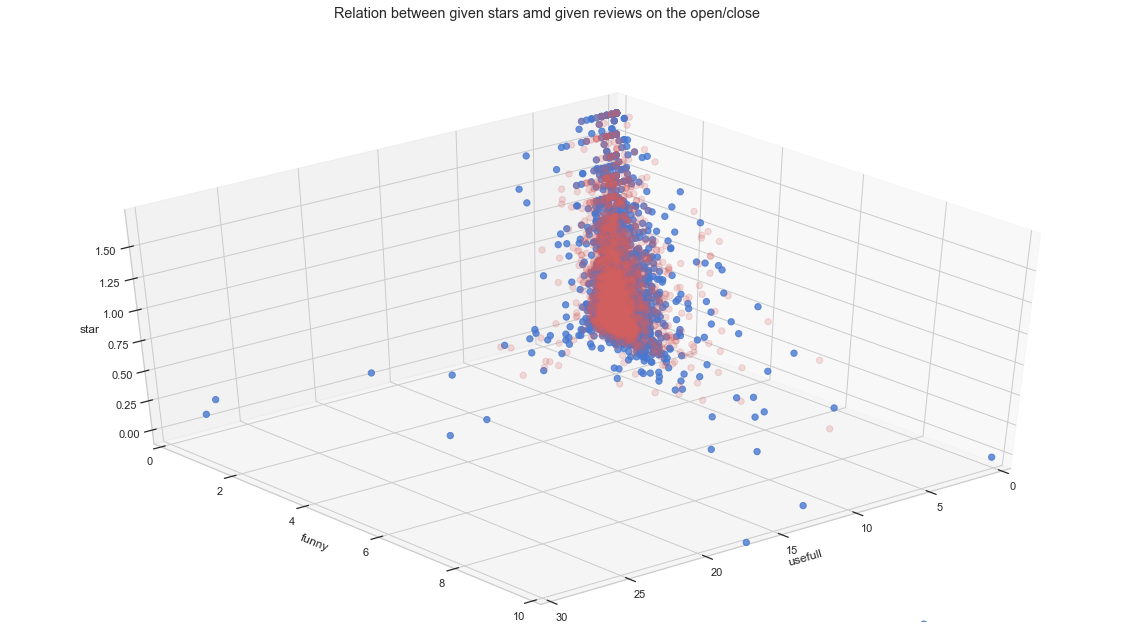

In [67]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(projection='3d')
ax.set(xlim=(0, 30), ylim=(0, 10))
ax.scatter(arizona_case_business_info[still_open].ratio_w_useful_reviews, arizona_case_business_info[still_open].ratio_w_funny_reviews, arizona_case_business_info[still_open].ratio_stars_review, color='b', s=40, alpha=0.8)
ax.scatter(arizona_case_business_info[~still_open].ratio_w_useful_reviews, arizona_case_business_info[~still_open].ratio_w_funny_reviews, arizona_case_business_info[~still_open].ratio_stars_review, color='r', s=40, alpha=0.2)

ax.set_xlabel('usefull')
ax.set_ylabel('funny')
ax.set_zlabel('star')
ax.view_init(40, 50)

plt.suptitle('Relation between given stars amd given reviews on the open/close')
plt.show()

__comments__ : The high ratio of usefull and funny reviews that seem to lead to a specific level of star, does not show any impact on the close/open information.

## 3.3 Spatial breakdown

This section focuses on the spatial informations. 

### 3.3.1 Maps

The touristics places were gathered from source planetware.com/tourist-attractions-/phoenix.

In [68]:
phoenix_city_center = [33.448400, -112.074000] #so it explains attractivity but also rent (the closest to cuty center is, the highest)

tourist_attractions = {
    'heard_museum' : [33.472500, -112.072200],
    'musical_museum' : [33.667621, -111.978492],
    'taliesin_west' : [33.606300, -111.845000],
    'old_town_scottsdale' : [33.498400, -111.926100],
    'hall_of_flame' : [33.447600, -111.953200],
    'phoenix_zoo' : [33.451200, -111.948000],
    'capitol' : [33.448100, -112.097100],
    'camelback_mountain' : [33.515100, -111.961900],
    'south_mountain_park_and_preserve' : [33.346700, -112.084700],
}

__* Heat map based on review activity and tourist attractions__

<img src="review_frequency_with_touristic_places.PNG"  style="width: 600px;"/>

__comments__ : Yelp review activity is about Phoenix ans its surroundings. This map shows the popularity of restaurants/ bars based on the number of reviews in Yelp. The highest reviewed restaurants seems to be the closest to city center and tourist attractions.

__* map based on this up and down rating__

In [69]:
hmap = folium.Map(location=[33.495194,-112.074000], tiles='Stamen Toner', zoom_start=10)
#hm_wide = HeatMap(list(zip(star_frequency.latitude.values, star_frequency.longitude.values)), 
#                  min_opacity=0.2,
#                  radius=5, blur=10,
#                  max_zoom=0.001)

#touristics places
for place in tourist_attractions:
    lat = tourist_attractions[place][0]
    long = tourist_attractions[place][1]
    folium.Marker([lat, long], popup=str(place)).add_to(hmap)

#+1.5
folium.Marker([arizona_case_business_info[arizona_case_business_info.difference_of_output_star>1.0].latitude.values[0], arizona_case_business_info[arizona_case_business_info.difference_of_output_star>1.0].longitude.values[0]], 
              popup = arizona_case_business_info[arizona_case_business_info.difference_of_output_star>1.0]['name'].iloc[0], 
              icon=folium.Icon(color='orange')).add_to(hmap)
#+1.0
folium.Marker([arizona_case_business_info[arizona_case_business_info.difference_of_output_star==1.0]['latitude'].iloc[0], arizona_case_business_info[arizona_case_business_info.difference_of_output_star==1.0]['longitude'].iloc[0]], 
              popup =  arizona_case_business_info[arizona_case_business_info.difference_of_output_star==1.0]['name'].iloc[0], 
              icon=folium.Icon(color='green')).add_to(hmap)
folium.Marker([arizona_case_business_info[arizona_case_business_info.difference_of_output_star==1.0]['latitude'].iloc[1], arizona_case_business_info[arizona_case_business_info.difference_of_output_star==1.0]['longitude'].iloc[1]], 
              popup =  arizona_case_business_info[arizona_case_business_info.difference_of_output_star==1.0]['name'].iloc[1], 
              icon=folium.Icon(color='green')).add_to(hmap)
#-1.0
folium.Marker([arizona_case_business_info[arizona_case_business_info.difference_of_output_star==-1.0]['latitude'].iloc[0], arizona_case_business_info[arizona_case_business_info.difference_of_output_star==1.0]['longitude'].iloc[0]], 
              popup =  arizona_case_business_info[arizona_case_business_info.difference_of_output_star==-1.0]['name'].iloc[0], 
              icon=folium.Icon(color='red')).add_to(hmap)
folium.Marker([arizona_case_business_info[arizona_case_business_info.difference_of_output_star==-1.0]['latitude'].iloc[1], arizona_case_business_info[arizona_case_business_info.difference_of_output_star==1.0]['longitude'].iloc[1]], 
              popup =  arizona_case_business_info[arizona_case_business_info.difference_of_output_star==-1.0]['name'].iloc[1], 
              icon=folium.Icon(color='red')).add_to(hmap)
#+0.5
for loc in arizona_case_business_info[arizona_case_business_info.difference_of_output_star==0.5][['latitude', 'longitude']].values:
    folium.Circle(
        radius=85,
        location=list(loc),
        color='darkgreen',
        fill=True,
    ).add_to(hmap)

#-0.5
for loc in arizona_case_business_info[arizona_case_business_info.difference_of_output_star==-0.5][['latitude', 'longitude']].values:
    folium.Circle(
        radius=90,
        location=list(loc),
        color='darkred',
        fill=True,
    ).add_to(hmap)
    
#hmap.add_child(hm_wide)
hmap

__comments__ :  there is no obvious link with those outliers and distances. Star grades depend less on the location rather than activity review.

### 3.3.2 haversine distances

source = https://www.yelp-press.com/company/fast-facts/default.aspx

We don't have information about who uses Yelp. According to US Demographics of Yelp Users (), the age is equally distributed, most of them went to college and 64% have an income of 100K+. Unfortunatly, this does not help about knowing if users of Yelp are mostly tourists travelling to another city or long-term habitants. 
However the maps above show that it seems that further we are from cities, the less activity review is. 
Hence, we can add this information in the database and turn latitude and longitude into distances. If we consider that Users are either tourists or habitants, restaurant activity will mostly depend on its geo location and its proximity to tourist attractions or city centers or work places.

__computation__

In [70]:
locations = arizona_case_business_info[['latitude', 'longitude']].values
dist_to_phoenix_city_center = []
for l in range(0,len(locations)):
    dist_to_phoenix_city_center.append(haversine_distances([locations[l], phoenix_city_center])[0,1])
arizona_case_business_info['dist_to_phoenix_city_center'] = dist_to_phoenix_city_center

min_dist_to_attraction = []
for l in range(0,len(locations)):
    dist_to_attraction = np.zeros((len(tourist_attractions))) 
    for i, j in enumerate(tourist_attractions):
        dist_to_attraction[i] = haversine_distances([locations[l], tourist_attractions[j]])[0,1]
    min_dist_to_attraction.append(min(dist_to_attraction))
    
arizona_case_business_info['min_dist_tourist_attraction'] = min_dist_to_attraction

In [71]:
arizona_case_business_info = arizona_case_business_info.drop(['latitude', 'longitude'], axis=1) #we don't need it anymore

__results__

In [72]:
arizona_case_business_info.head()

name  review_count  is_open  \
business_id                                                           
--Rsj71PBe31h5YljVseKA              Circle K             9        1   
-01XupAWZEXbdNbxNg5mEg            18 Degrees            99        1   
-050d_XIor1NpCuWkbIVaQ  Matt's Big Breakfast           703        0   
-0Sgh0QlUKVsWosCWJzGqQ        Domino's Pizza            47        1   
-0WegMt6Cy966qlDKhu6jA      Game Seven Grill           100        1   

                                                               attributes  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA  {'OutdoorSeating': 'False', 'RestaurantsTakeOu...   
-01XupAWZEXbdNbxNg5mEg  {'RestaurantsGoodForGroups': 'True', 'Music': ...   
-050d_XIor1NpCuWkbIVaQ  {'Corkage': 'False', 'RestaurantsReservations'...   
-0Sgh0QlUKVsWosCWJzGqQ  {'GoodForKids': 'True', 'BusinessAcceptsCredit...   
-0WegMt6Cy966qlDKhu6jA  {'Caters': 'False', 'BikeParking': 'True', 'Am...   

                        ratio_stars_review  overall_star  true_mean_stars  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA            0.388889           3.5         3.200000   
-01XupAWZEXbdNbxNg5mEg            0.030303           3.0         3.067961   
-050d_XIor1NpCuWkbIVaQ            0.005690           4.0         3.995862   
-0Sgh0QlUKVsWosCWJzGqQ            0.042553           2.0         1.979592   
-0WegMt6Cy966qlDKhu6jA            0.020000           2.0         2.039216   

                        true_std_stars  true_median_stars  true_iqr_stars  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA        1.751190                4.0             3.5   
-01XupAWZEXbdNbxNg5mEg        1.450234                3.0             2.0   
-050d_XIor1NpCuWkbIVaQ        1.111832                4.0             2.0   
-0Sgh0QlUKVsWosCWJzGqQ        1.391788                1.0             2.0   
-0WegMt6Cy966qlDKhu6jA        1.159733                2.0             2.0   

                        rounded_mean_stars  difference_of_output_star  \
business_id                                                             
--Rsj71PBe31h5YljVseKA                 3.0                        0.5   
-01XupAWZEXbdNbxNg5mEg                 3.0                        0.0   
-050d_XIor1NpCuWkbIVaQ                 4.0                        0.0   
-0Sgh0QlUKVsWosCWJzGqQ                 2.0                        0.0   
-0WegMt6Cy966qlDKhu6jA                 2.0                        0.0   

                        ratio_w_funny_reviews  ratio_w_cool_reviews  \
business_id                                                           
--Rsj71PBe31h5YljVseKA               0.444444              0.444444   
-01XupAWZEXbdNbxNg5mEg               0.606061              0.767677   
-050d_XIor1NpCuWkbIVaQ               0.937411              1.088193   
-0Sgh0QlUKVsWosCWJzGqQ               0.574468              0.148936   
-0WegMt6Cy966qlDKhu6jA               0.280000              0.410000   

                        ratio_w_useful_reviews  dist_to_phoenix_city_center  \
business_id                                                                   
--Rsj71PBe31h5YljVseKA                0.333333                     0.265384   
-01XupAWZEXbdNbxNg5mEg                1.484848                     0.215460   
-050d_XIor1NpCuWkbIVaQ                1.910384                     0.008330   
-0Sgh0QlUKVsWosCWJzGqQ                0.851064                     0.070987   
-0WegMt6Cy966qlDKhu6jA                0.680000                     0.003728   

                        min_dist_tourist_attraction  
business_id                                          
--Rsj71PBe31h5YljVseKA                     0.090541  
-01XupAWZEXbdNbxNg5mEg                     0.039541  
-050d_XIor1NpCuWkbIVaQ                     0.014057  
-0Sgh0QlUKVsWosCWJzGqQ                     0.034841  
-0WegMt6Cy966qlDKhu6jA            

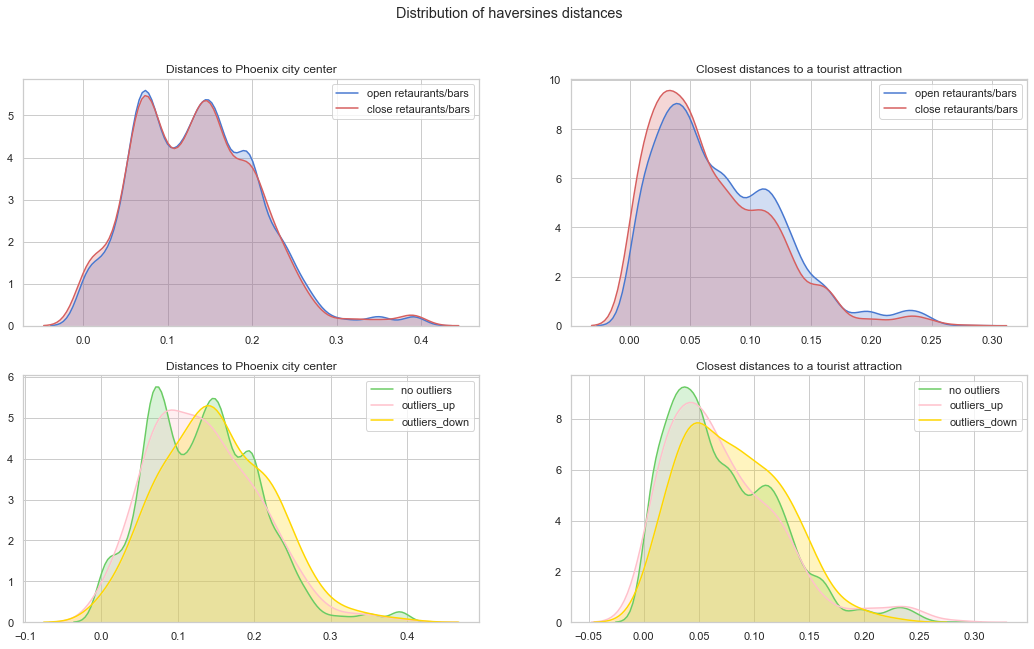

In [73]:
plt.figure(figsize=(18, 10), linewidth=1)
still_open = arizona_case_business_info.is_open==1

plt.subplot(2,2,1)
sns.kdeplot(arizona_case_business_info[still_open]["dist_to_phoenix_city_center"], shade=True, color="b", label='open retaurants/bars')
sns.kdeplot(arizona_case_business_info[~still_open]["dist_to_phoenix_city_center"], shade=True, color="r", label='close retaurants/bars')
plt.title('Distances to Phoenix city center')

plt.subplot(2,2,2)
sns.kdeplot(arizona_case_business_info[still_open]["min_dist_tourist_attraction"], shade=True, color="b", label='open retaurants/bars')
sns.kdeplot(arizona_case_business_info[~still_open]["min_dist_tourist_attraction"], shade=True, color="r", label='close retaurants/bars')
plt.title('Closest distances to a tourist attraction')

plt.subplot(2,2,3)
sns.kdeplot(arizona_case_business_info[arizona_case_business_info.difference_of_output_star == 0]["dist_to_phoenix_city_center"], shade=True, color="g", label='no outliers')
sns.kdeplot(arizona_case_business_info[arizona_case_business_info.difference_of_output_star > 0]["dist_to_phoenix_city_center"], shade=True, color="pink", label='outliers_up')
sns.kdeplot(arizona_case_business_info[arizona_case_business_info.difference_of_output_star < 0]["dist_to_phoenix_city_center"], shade=True, color="gold", label='outliers_down')
plt.title('Distances to Phoenix city center')

plt.subplot(2,2,4)
sns.kdeplot(arizona_case_business_info[arizona_case_business_info.difference_of_output_star == 0]["min_dist_tourist_attraction"], shade=True, color="g", label='no outliers')
sns.kdeplot(arizona_case_business_info[arizona_case_business_info.difference_of_output_star > 0]["min_dist_tourist_attraction"], shade=True, color="pink", label='outliers_up')
sns.kdeplot(arizona_case_business_info[arizona_case_business_info.difference_of_output_star < 0]["min_dist_tourist_attraction"], shade=True, color="gold", label='outliers_down')
plt.title('Closest distances to a tourist attraction')

plt.suptitle('Distribution of haversines distances')
plt.show()

__comments__: 
- distribution of distances to Phoenix center is bimodal, and this does not depend if the restaurant closed,
- there is a slight difference in the dist to tourist attraction between the 2 distributions, but no obvious insight as an explanation of open/close 
- Distances to city center look like more bell curved if it's a oultlier. Those that got up-rated are in mean closer to city center. Distances to a touristic place don't show any pattern. However these insights don't reveal that the hypothesis of random events is unlikely.

## 3.3 Temporal insights

### 3.3.1 Temporal evolution

In [74]:
arizona_case['date'] = pd.to_datetime(arizona_case['date'], format='%d/%m/%Y %H:%M:%S')
arizona_case.set_index(arizona_case['date'], inplace=True) #we change the index by the date

print('reviews in arizona started from', arizona_case.date.min(), 'to :', arizona_case.date.max())

reviews in arizona started from 2005-03-08 22:19:43 to : 2018-11-14 18:13:16


In [75]:
arizona_case.head(2)

business_id      name   latitude   longitude  \
date                                                                           
2017-11-16 23:20:36  --Rsj71PBe31h5YljVseKA  Circle K  33.713424 -112.099279   
2016-10-30 03:31:25  --Rsj71PBe31h5YljVseKA  Circle K  33.713424 -112.099279   

                     review_count  is_open  \
date                                         
2017-11-16 23:20:36             9        1   
2016-10-30 03:31:25             9        1   

                                                            attributes  \
date                                                                     
2017-11-16 23:20:36  {'OutdoorSeating': 'False', 'RestaurantsTakeOu...   
2016-10-30 03:31:25  {'OutdoorSeating': 'False', 'RestaurantsTakeOu...   

                     ratio_stars_review  cool                date  funny  \
date                                                                       
2017-11-16 23:20:36            0.388889     0 2017-11-16 23:20:36      0   
2016-10-30 03:31:25            0.388889     0 2016-10-30 03:31:25      0   

                                  review_id  \
date                                          
2017-11-16 23:20:36  lAreRgokYmhprSC99VQlcA   
2016-10-30 03:31:25  xdWHHJZIIUIQfuGRzIRaPQ   

                                                                  text  \
date                                                                     
2017-11-16 23:20:36  This Circle K store was clean and well run whe...   
2016-10-30 03:31:25  We love this store. We will always drive out o...   

                     useful                 user_id  overall_star  \
date                                                                
2017-11-16 23:20:36       0  813qGlE2OI7oy8yhd2K4rg           3.5   
2016-10-30 03:31:25       0  _O4k9mJHTOfKat2lhaQVpQ           3.5   

                     single_client_star  useful_binned  cool_binned  \
date                                                                  
2017-11-16 23:20:36                   1              1            1   
2016-10-30 03:31:25                   5              1            1   

                     funny_binned  
date                               
2017-11-16 23:20:36             1  
2016-10-30 03:31:25             1

In [76]:
monthly_2018 = arizona_case[arizona_case.index.year==2018].resample('M').count()[['date']]
monthly_2018 = list(monthly_2018.date.values)
monthly_2018.append(0)
monthly_2017 = arizona_case[arizona_case.index.year==2017].resample('M').count()[['date']]
monthly_2016 = arizona_case[arizona_case.index.year==2016].resample('M').count()[['date']]
monthly_2015 = arizona_case[arizona_case.index.year==2015].resample('M').count()[['date']]
monthly_2014 = arizona_case[arizona_case.index.year==2014].resample('M').count()[['date']]
monthly_2008 = arizona_case[arizona_case.index.year==2008].resample('M').count()[['date']]

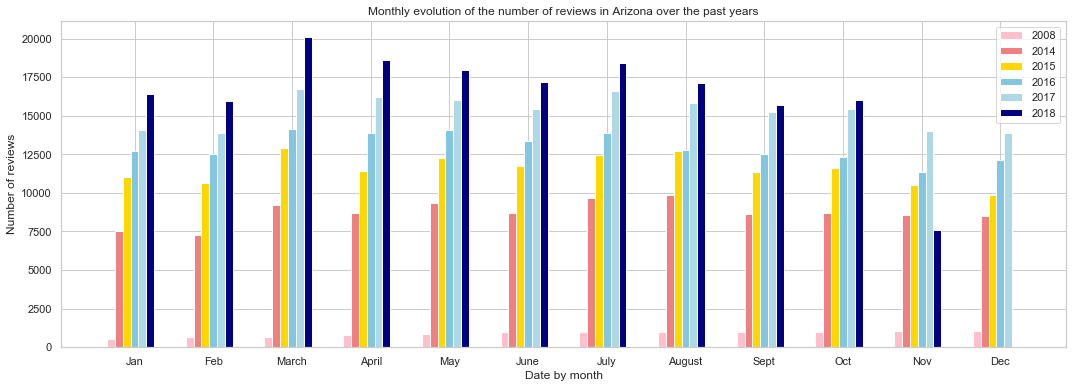

In [77]:
plt.figure(figsize = (18, 6))

r1 = range(0, len(monthly_2017))
barWidth = 0.1
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

m8 = plt.bar(r1, monthly_2008.date.values, width=barWidth, edgecolor='white', color='pink', label='2008')
m14 = plt.bar(r2, monthly_2014.date.values,  width=barWidth, edgecolor='white', color='lightcoral', label='2014')
m15 = plt.bar(r3, monthly_2015.date.values, width=barWidth, edgecolor='white', color='gold', label='2015')
m16 = plt.bar(r4, monthly_2016.date.values, width=barWidth, edgecolor='white', color='c', label='2016')
m17 = plt.bar(r5, monthly_2017.date.values, width=barWidth, edgecolor='white', color='lightblue', label='2017')
m18 = plt.bar(r6, monthly_2018, width=barWidth, edgecolor='white', color='navy', label='2018')

plt.xlabel('Date by month')
plt.ylabel('Number of reviews')
plt.title('Monthly evolution of the number of reviews in Arizona over the past years')
plt.xticks(np.arange(12)+0.3, ('Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'Sept', 'Oct', 'Nov', 'Dec'))
plt.legend(handles=[m8, m14, m15, m16, m17, m18])
plt.show()

__comments__: 
- through years YElp gets importance in Arizona and seems to play an influential role
- there is no season effect on review activity: this means that it is not specificly used by tourists so dististances to touristic places may not be a huge driver

### 3.3.2 temporal dynamics

__first overview of the most extreme ouliers__

we look at the outliers to see if it gives us ideas about time patterns

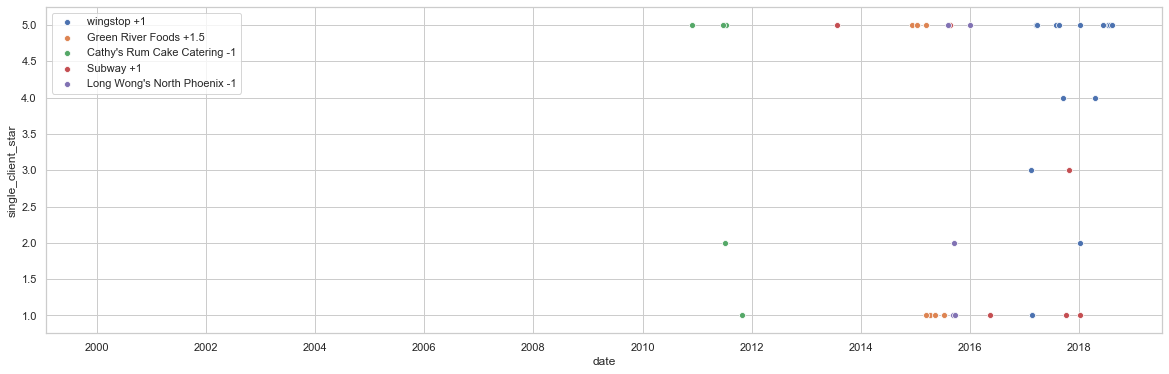

In [79]:
plt.figure(figsize=(20,6))
#plt.subplot(1,2,1)
sns.scatterplot(x='date', y='single_client_star', data=arizona_case[arizona_case.business_id=='pRitNmkahcveSE9XsoEdMw'], label='wingstop +1')
sns.scatterplot(x='date', y='single_client_star', data=arizona_case[arizona_case.business_id=='jndyQsXTF2tICjZ605X2Cw'], label='Green River Foods +1.5')
sns.scatterplot(x='date', y='single_client_star', data=arizona_case[arizona_case.business_id=='CFortoBLONVZ8YF-nY5H3A'], label="Cathy's Rum Cake Catering -1")
sns.scatterplot(x='date', y='single_client_star', data=arizona_case[arizona_case.business_id=='d4pXR8yVuJIm6Q3HuRYBfw'], label="Subway +1")
sns.scatterplot(x='date', y='single_client_star', data=arizona_case[arizona_case.business_id=='656XUeBmMzyvU62yYHptxQ'], label="Long Wong's North Phoenix -1")
#plt.xlim(arizona_case.date.sort_values()[180000], arizona_case.date.max())

#plt.subplot(1,2,2)

#sns.scatterplot(x='date', y='single_client_star', data=arizona_case[arizona_case['business_id'].isin(list(unique_business_info[unique_business_info.difference_of_output_star==0].index))], )
#sns.scatterplot(x='date', y='single_client_star', data=arizona_case[arizona_case['business_id'].isin(list(unique_business_info[unique_business_info.difference_of_output_star==0].index))], )

#ax.set_xlim(arizona_case.date.sort_values()[180000], arizona_case.date.max())
#ax.set_title('inliers')

plt.show()

__comments__ : 
Looking at outliers does not help to find any frequency patterns. Hence we will create in the following section time series features and analyse the outputs:
  - number of days between the beginning of Yelp and first review of each business
  - number of days between the first review and the last one
  - minimum hours between 2 reviews
  - maximum hours between 2 reviews
  - average frequency between 2 reviews

__adding time information__

In [80]:
#number of days between the beginning of Yelp of first review of eacg business
arizona_case_business_info['born_in_yelp_d'] = (arizona_case.groupby(['business_id'])['date'].min() - arizona_case.index.min()).astype('timedelta64[D]')

In [81]:
#number of days between the first review they got and the last one
arizona_case_business_info['age_in_yelp_d'] = (arizona_case.groupby(['business_id'])['date'].max() - arizona_case.groupby(['business_id'])['date'].min()).astype('timedelta64[D]')

In [82]:
#number of min hours between 2 reviews
#number of max hours between 2 reviews
#average frequency in hours between 2 reviews

min_between_reviews_in_h = []
max_between_reviews_in_h = []
average_between_reviews_in_h = []

for b_id in arizona_case_business_info.index.values:
    diff_between_each_date = arizona_case[arizona_case.business_id==b_id].sort_index().date.diff()
    min_between_reviews_in_h.append(diff_between_each_date.min().total_seconds() // 3600)
    max_between_reviews_in_h.append(diff_between_each_date.max().total_seconds() // 3600)
    average_between_reviews_in_h.append(diff_between_each_date.mean().total_seconds() // 3600)

In [83]:
arizona_case_business_info['min_between_reviews_in_h'] = min_between_reviews_in_h
arizona_case_business_info['max_between_reviews_in_h'] = max_between_reviews_in_h
arizona_case_business_info['average_between_reviews_in_h'] = average_between_reviews_in_h

__results__:

In [84]:
arizona_case_business_info.head(2)

name  review_count  is_open  \
business_id                                                 
--Rsj71PBe31h5YljVseKA    Circle K             9        1   
-01XupAWZEXbdNbxNg5mEg  18 Degrees            99        1   

                                                               attributes  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA  {'OutdoorSeating': 'False', 'RestaurantsTakeOu...   
-01XupAWZEXbdNbxNg5mEg  {'RestaurantsGoodForGroups': 'True', 'Music': ...   

                        ratio_stars_review  overall_star  true_mean_stars  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA            0.388889           3.5         3.200000   
-01XupAWZEXbdNbxNg5mEg            0.030303           3.0         3.067961   

                        true_std_stars  true_median_stars  true_iqr_stars  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA        1.751190                4.0             3.5   
-01XupAWZEXbdNbxNg5mEg        1.450234                3.0             2.0   

                        ...  ratio_w_funny_reviews  ratio_w_cool_reviews  \
business_id             ...                                                
--Rsj71PBe31h5YljVseKA  ...               0.444444              0.444444   
-01XupAWZEXbdNbxNg5mEg  ...               0.606061              0.767677   

                        ratio_w_useful_reviews  dist_to_phoenix_city_center  \
business_id                                                                   
--Rsj71PBe31h5YljVseKA                0.333333                     0.265384   
-01XupAWZEXbdNbxNg5mEg                1.484848                     0.215460   

                        min_dist_tourist_attraction  born_in_yelp_d  \
business_id                                                           
--Rsj71PBe31h5YljVseKA                     0.090541          2470.0   
-01XupAWZEXbdNbxNg5mEg                     0.039541          1666.0   

                        age_in_yelp_d  min_between_reviews_in_h  \
business_id                                                       
--Rsj71PBe31h5YljVseKA         2450.0                     171.0   
-01XupAWZEXbdNbxNg5mEg         3330.0                       0.0   

                        max_between_reviews_in_h  average_between_reviews_in_h  
business_id                                                                     
--Rsj71PBe31h5YljVseKA                   22420.0                        6534.0  
-01XupAWZEXbdNbxNg5mEg                    4799.0                         783.0  

[2 rows x 22 columns]

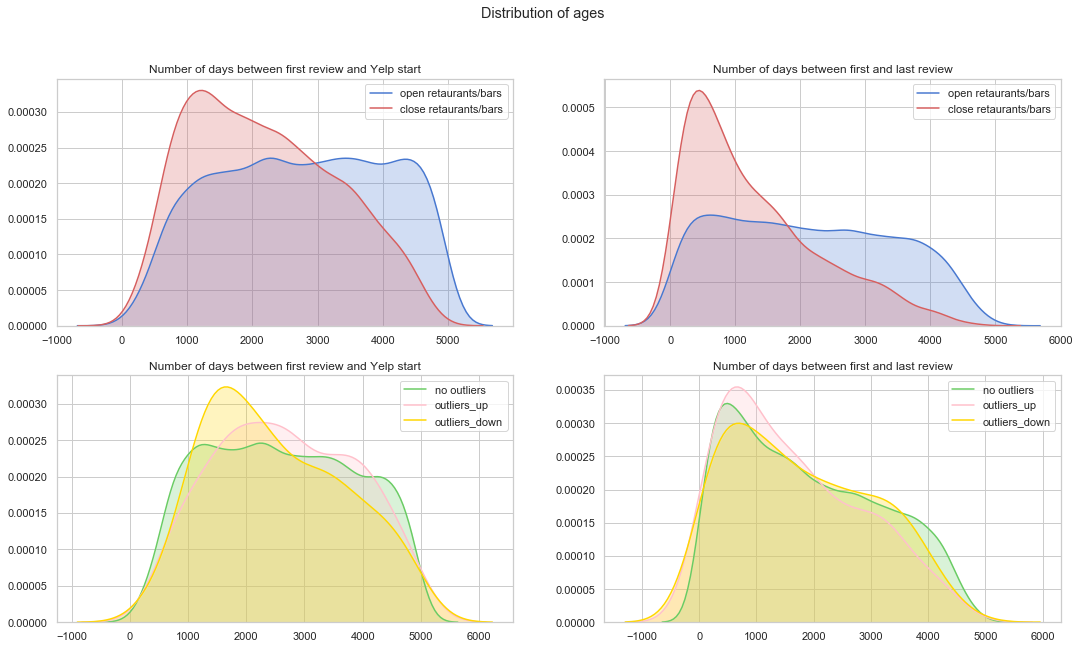

In [85]:
plt.figure(figsize=(18, 10), linewidth=1)
still_open = arizona_case_business_info.is_open==1

plt.subplot(2,2,1)
sns.kdeplot(arizona_case_business_info[still_open]["born_in_yelp_d"], shade=True, color="b", label='open retaurants/bars')
sns.kdeplot(arizona_case_business_info[~still_open]["born_in_yelp_d"], shade=True, color="r", label='close retaurants/bars')
plt.title('Number of days between first review and Yelp start')

plt.subplot(2,2,2)
sns.kdeplot(arizona_case_business_info[still_open]["age_in_yelp_d"], shade=True, color="b", label='open retaurants/bars')
sns.kdeplot(arizona_case_business_info[~still_open]["age_in_yelp_d"], shade=True, color="r", label='close retaurants/bars')
plt.title('Number of days between first and last review')

plt.subplot(2,2,3)
sns.kdeplot(arizona_case_business_info[arizona_case_business_info.difference_of_output_star == 0]["born_in_yelp_d"], shade=True, color="g", label='no outliers')
sns.kdeplot(arizona_case_business_info[arizona_case_business_info.difference_of_output_star > 0]["born_in_yelp_d"], shade=True, color="pink", label='outliers_up')
sns.kdeplot(arizona_case_business_info[arizona_case_business_info.difference_of_output_star < 0]["born_in_yelp_d"], shade=True, color="gold", label='outliers_down')
plt.title('Number of days between first review and Yelp start')

plt.subplot(2,2,4)
sns.kdeplot(arizona_case_business_info[arizona_case_business_info.difference_of_output_star == 0]["age_in_yelp_d"], shade=True, color="g", label='no outliers')
sns.kdeplot(arizona_case_business_info[arizona_case_business_info.difference_of_output_star > 0]["age_in_yelp_d"], shade=True, color="pink", label='outliers_up')
sns.kdeplot(arizona_case_business_info[arizona_case_business_info.difference_of_output_star < 0]["age_in_yelp_d"], shade=True, color="gold", label='outliers_down')
plt.title('Number of days between first and last review')

plt.suptitle('Distribution of ages')
plt.show()

__comments__ : The distributions of ages toward the target open/close have a different shape. While open restaurants have constant distribution, closed one are roughly right skewed. In average the closed restaurants have recorded into Yelp platform around 3 years after its creation, around 2008 and last around 2 years.
Regarding the outlier case, the distribution of first reviews shows that those that got under-rated have in average got their firest review 4 years after Yelp creation. However, there's not obvious pattern about outliers against time and the most likely conclusion is that those outliers are random.  

In [86]:
bins = [0,24,72,168,336,730,1460,2229] #within 1, 3 days, within 7 days, 14 days, a month, 2 months
average_between_reviews_in_h_binned = np.digitize(arizona_case_business_info.average_between_reviews_in_h, bins)
arizona_case_business_info['average_between_reviews_in_h_binned'] = average_between_reviews_in_h_binned

print(Counter(average_between_reviews_in_h_binned))

Counter({8: 3303, 5: 1857, 6: 1797, 4: 1267, 7: 1041, 3: 944, 2: 394, 1: 28})


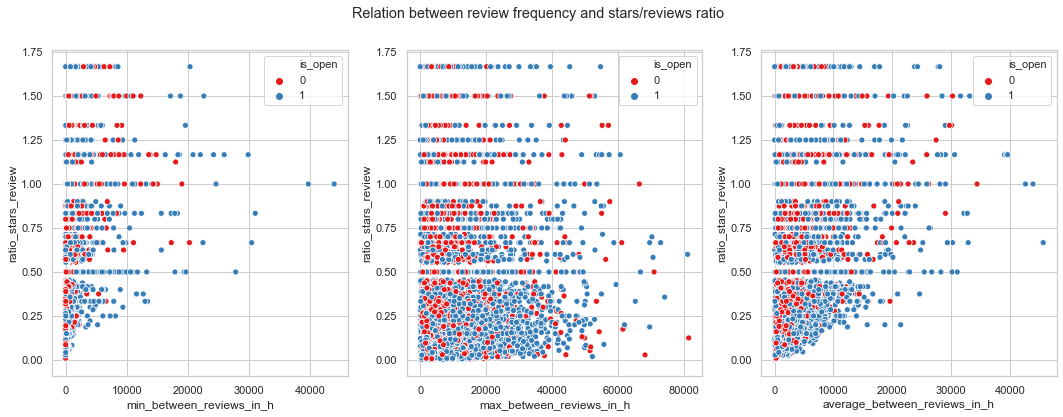

In [90]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.scatterplot(x='min_between_reviews_in_h', y='ratio_stars_review', data=arizona_case_business_info, hue='is_open', palette='Set1')
plt.subplot(1,3,2)
sns.scatterplot(x='max_between_reviews_in_h', y='ratio_stars_review', data=arizona_case_business_info, hue='is_open', palette='Set1')
plt.subplot(1,3,3)
sns.scatterplot(x='average_between_reviews_in_h', y='ratio_stars_review', data=arizona_case_business_info, hue='is_open', palette='Set1')
plt.suptitle('Relation between review frequency and stars/reviews ratio')
plt.show()

Text(0.5, 0.98, 'Relation between review frequency and stars/reviews ratio')

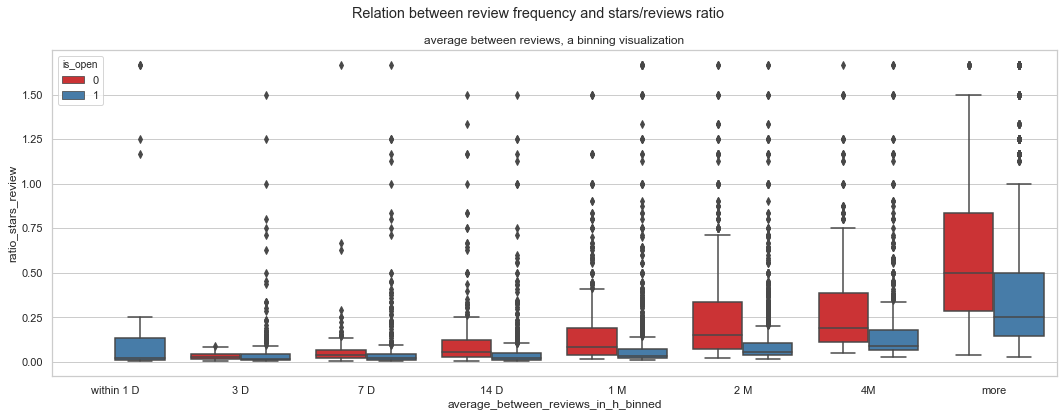

In [91]:
plt.figure(figsize=(18,6))
sns.boxplot(x='average_between_reviews_in_h_binned', y='ratio_stars_review', data=arizona_case_business_info, hue='is_open',  palette='Set1')
plt.xticks(range(0,len(bins)), ["within 1 D","3 D","7 D", "14 D", "1 M", "2 M", "4M", "more"])
plt.title('average between reviews, a binning visualization')

plt.suptitle('Relation between review frequency and stars/reviews ratio')

__comments__: It turns out that binning reviews frequencies shows a meaningfull output compared to scatterplot. Indeed, The higher the time is between 2 reviews, the higher is the median and iqr of close restaurant. The review frequency confirm clearly that restaurants can close because of a lack of attractiveness showed here by a low frequency review in Yelp.

# 4. Yelp a meaningful indicator in Arizona? - Review analysis perspective

In this part, the reviews clients wrote in Arizona are investigated. We mostly want to know the rate of stars missclassification regarding review contents. If this rate turns out to be high, then in addition to 6% of errors in the overall star computation, the overall star we look at is not such significant.  

In [92]:
arizona_case_reviews = arizona_case[['review_id', 'text', 'useful_binned', 'funny_binned', 'single_client_star']] #saving in this dataframe the information we look at for easier using.
arizona_case_reviews.head(2)

review_id  \
date                                          
2017-11-16 23:20:36  lAreRgokYmhprSC99VQlcA   
2016-10-30 03:31:25  xdWHHJZIIUIQfuGRzIRaPQ   

                                                                  text  \
date                                                                     
2017-11-16 23:20:36  This Circle K store was clean and well run whe...   
2016-10-30 03:31:25  We love this store. We will always drive out o...   

                     useful_binned  funny_binned  single_client_star  
date                                                                  
2017-11-16 23:20:36              1             1                   1  
2016-10-30 03:31:25              1             1                   5

## 4.1 First insights about review content

### 4.1.1 word cloud

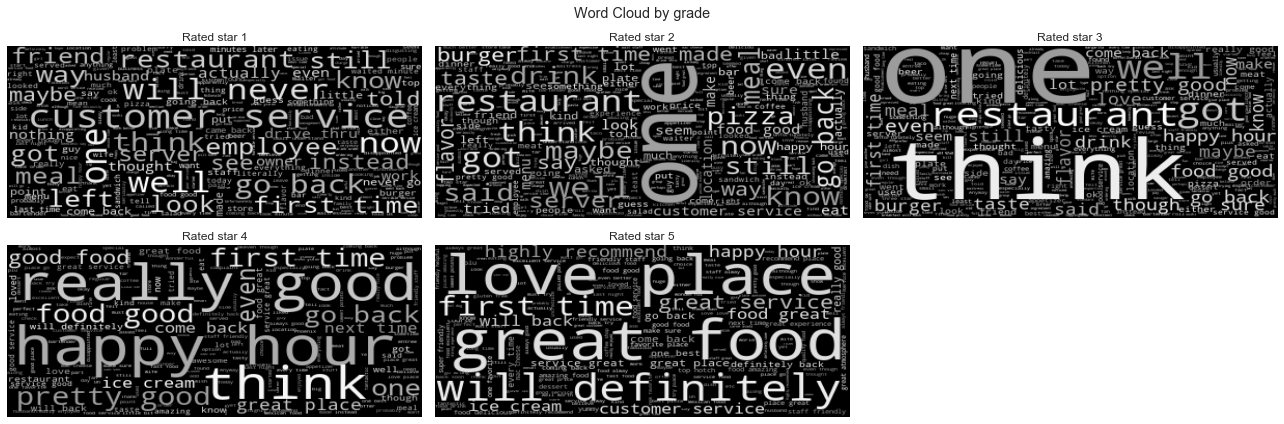

In [94]:
# Coloring Function
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

# Word Cloud initialization
wc = WordCloud(background_color="black", max_words=1000, margin=0)

# Visualize Word Cloud
plt.figure(figsize=(18, 6), linewidth=1)
for i, grade in enumerate([1,2,3,4,5]):
    plt.subplot(2, 3, i+1)
    wc.generate(arizona_case_reviews.text[arizona_case_reviews.single_client_star==grade].str.cat(sep=' '))
    plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3), interpolation='bilinear', aspect='auto')
    plt.axis("off")
    plt.title('Rated star ' + str(grade))

plt.suptitle('Word Cloud by grade')
plt.tight_layout(rect=[0, 0, 1, .95]);

__comments__ : Word Cloud is used to have a firt sight of the content of reviews per star. This helps to have an idea of how successful can be the text classification. 
The results show that the most common words throughout categories are different and pretty relevant, especially in category 5, 4 and 1. However, the classification might struggle more about class 2 and 3. How can the sentiment classification can be improved then ? In the following part, we will have a look into emojis and check if this can improve the upcoming classification task.

### 4.1.2 Sentiment overview through emoticons

In [93]:
#gathering emojis
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [94]:
#creating functions checking if a specific review has a sad or happy sentiment 
def is_emoji_happy(txt):
    for word in txt.split():
        if word in emoticons_happy:
            return True
    return False

def is_emoji_sad(txt):
    for word in txt.split():
        if word in emoticons_sad:
            return True
    return False

In [95]:
emoji_sentiment = []

for rev in arizona_case_reviews['text']:
    if is_emoji_happy(rev) and not is_emoji_sad(rev):
        emoji_sentiment.append('happy')
    elif not is_emoji_happy(rev) and is_emoji_sad(rev):
        emoji_sentiment.append('sad')
    else:
        emoji_sentiment.append('unclear')

In [96]:
arizona_case_reviews['emojis'] = arizona_case_reviews['text'].apply(lambda x: re.sub(r'[\w\s]','',x))
arizona_case_reviews['emoji_sentiment'] = emoji_sentiment

dummies_sentiment = pd.get_dummies(arizona_case_reviews['emoji_sentiment'])
arizona_case_reviews['happy'] = dummies_sentiment['happy']
arizona_case_reviews['sad'] = dummies_sentiment['sad']

__results__

In [97]:
arizona_case_reviews.head()

review_id  \
date                                          
2017-11-16 23:20:36  lAreRgokYmhprSC99VQlcA   
2016-10-30 03:31:25  xdWHHJZIIUIQfuGRzIRaPQ   
2018-08-28 15:23:47  pGs6RtrlN3noRBoHHGcMLA   
2018-02-27 06:47:42  5tibBO5RqHuqxrPxx3CaKA   
2014-04-09 22:45:13  2DNxaJfpqjycGRCjVLt3Tw   

                                                                  text  \
date                                                                     
2017-11-16 23:20:36  This Circle K store was clean and well run whe...   
2016-10-30 03:31:25  We love this store. We will always drive out o...   
2018-08-28 15:23:47  This is one of the worst Circle K's i have eve...   
2018-02-27 06:47:42  Usually come to this circle k to use my frys p...   
2014-04-09 22:45:13  This is my favorite Circle K!  The employees a...   

                     useful_binned  funny_binned  single_client_star  \
date                                                                   
2017-11-16 23:20:36              1             1                   1   
2016-10-30 03:31:25              1             1                   5   
2018-08-28 15:23:47              1             1                   1   
2018-02-27 06:47:42              1             1                   4   
2014-04-09 22:45:13              1             1                   5   

                                                     emojis emoji_sentiment  \
date                                                                          
2017-11-16 23:20:36  .'-.(),'.,'.,.,$.$.#.$.,,,.',.,.,,.-'.         unclear   
2016-10-30 03:31:25                        .!!!,...'!!!!!!!         unclear   
2018-08-28 15:23:47                             '..........         unclear   
2018-02-27 06:47:42                            .!.,'..'$.,.         unclear   
2014-04-09 22:45:13                                  !....!         unclear   

                     happy  sad  
date                             
2017-11-16 23:20:36      0    0  
2016-10-30 03:31:25      0    0  
2018-08-28 15:23:47      0    0  
2018-02-27 06:47:42      0    0  
2014-04-09 22:45:13      0    0

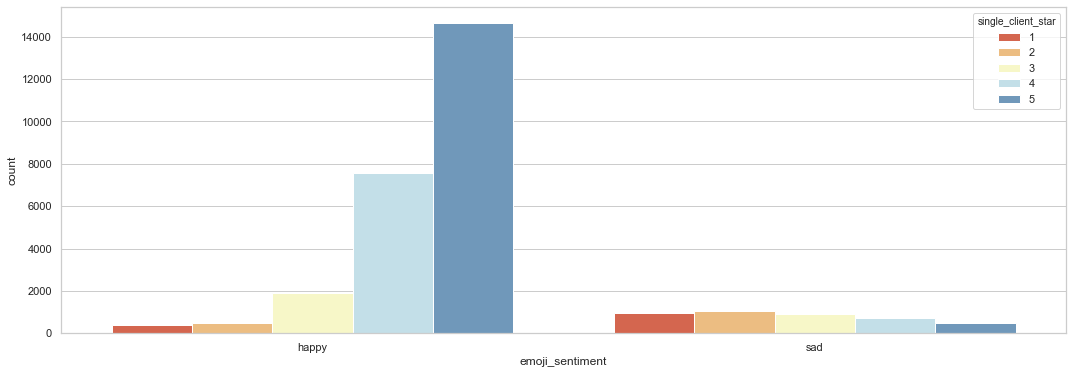

In [98]:
plt.figure(figsize=(18,6))
sns.countplot(x='emoji_sentiment', data=arizona_case_reviews[arizona_case_reviews.emoji_sentiment!='unclear'], hue='single_client_star', palette='RdYlBu')
plt.show()

__comments__ : The above count plot shows that emoji recognition seems useful. Happy sentiment through emoji research corresponds clearly to highest grades (4 and 5) and sad emojis to lowest grades. It might help us in the classification accuracy.

### 4.1.3 Sentiment overview through sentiment polarity values

In [99]:
arizona_case_reviews['polarity'] = arizona_case_reviews['text'].map(lambda text: TextBlob(text).sentiment.polarity) 

__results__

In [119]:
arizona_case_reviews.head()

review_id  \
date                                          
2017-11-16 23:20:36  lAreRgokYmhprSC99VQlcA   
2016-10-30 03:31:25  xdWHHJZIIUIQfuGRzIRaPQ   
2018-08-28 15:23:47  pGs6RtrlN3noRBoHHGcMLA   
2018-02-27 06:47:42  5tibBO5RqHuqxrPxx3CaKA   
2014-04-09 22:45:13  2DNxaJfpqjycGRCjVLt3Tw   

                                                                  text  \
date                                                                     
2017-11-16 23:20:36  This Circle K store was clean and well run whe...   
2016-10-30 03:31:25  We love this store. We will always drive out o...   
2018-08-28 15:23:47  This is one of the worst Circle K's i have eve...   
2018-02-27 06:47:42  Usually come to this circle k to use my frys p...   
2014-04-09 22:45:13  This is my favorite Circle K!  The employees a...   

                     useful_binned  funny_binned  single_client_star  \
date                                                                   
2017-11-16 23:20:36              1             1                   1   
2016-10-30 03:31:25              1             1                   5   
2018-08-28 15:23:47              1             1                   1   
2018-02-27 06:47:42              1             1                   4   
2014-04-09 22:45:13              1             1                   5   

                                                     emojis emoji_sentiment  \
date                                                                          
2017-11-16 23:20:36  .'-.(),'.,'.,.,$.$.#.$.,,,.',.,.,,.-'.         unclear   
2016-10-30 03:31:25                        .!!!,...'!!!!!!!         unclear   
2018-08-28 15:23:47                             '..........         unclear   
2018-02-27 06:47:42                            .!.,'..'$.,.         unclear   
2014-04-09 22:45:13                                  !....!         unclear   

                     happy  sad  polarity  \
date                                        
2017-11-16 23:20:36      0    0 -0.008320   
2016-10-30 03:31:25      0    0  0.481829   
2018-08-28 15:23:47      0    0 -1.000000   
2018-02-27 06:47:42      0    0  0.054167   
2014-04-09 22:45:13      0    0  0.493750   

                                                     text_preprocessed  
date                                                                    
2017-11-16 23:20:36  circle k store clean well run first moved nort...  
2016-10-30 03:31:25  love store always drive way go huge reason mik...  
2018-08-28 15:23:47  one worst circle k ever horrible customer serv...  
2018-02-27 06:47:42  usually come circle k use fry point gas save 1...  
2014-04-09 22:45:13  favorite circle k employee nice friendly also ...

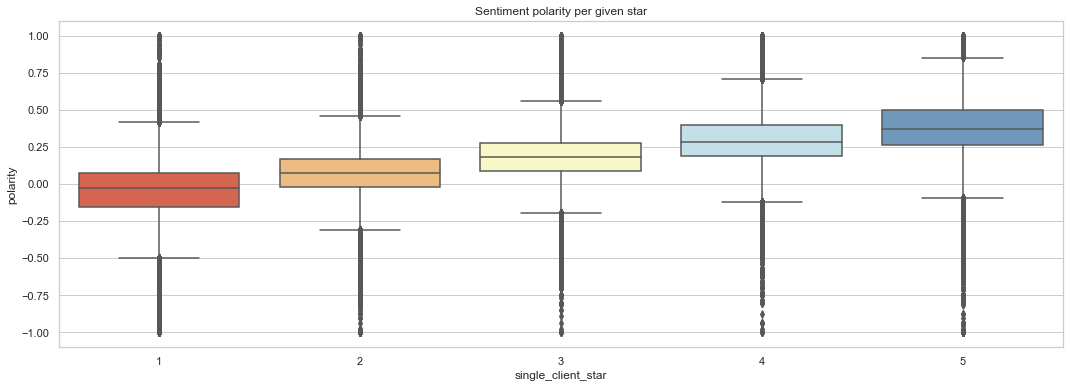

In [101]:
plt.figure(figsize=(18,6))
sns.boxplot(x='single_client_star', y='polarity', data=arizona_case_reviews, palette='RdYlBu')
plt.title('Sentiment polarity per given star')
plt.show()

__comments__: Even though we observe many outliers for each star, the polarity average goes higher as the star increases. This is a good sign of sentiment classification. 

## 4.2 Grade missclassification ?

In order to see if the graded star matches well with the description, we perform a classification task.

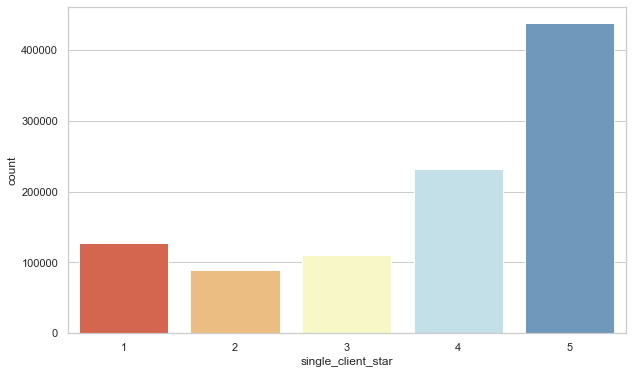

In [102]:
plt.figure(figsize=(10,6))
sns.countplot(x='single_client_star', data=arizona_case_reviews, palette='RdYlBu')
plt.show()

__comment__: a bit imbalanced regarding classes 5 and 2 but considering the initial amount of observations per class, the train set will have enough data. Also having balanced classes in text classification is less relevant than in other cases.

### 4.2.1 text preprocessing

In [104]:
lemmatizer = WordNetLemmatizer()

def pre_process(text):
    
    # Normalize text to same unicode
    # Replacing non-breaking space ('\xc2\xa0') with a space.
    text = unicodedata.normalize("NFKD", text)
    
    # Lower Case
    text = text.lower()
    
    # Removing Punctuation
    text = re.sub(r'[^\w\s]','',text)
    
   #Removal of Stop Words
    text = " ".join(x for x in text.split() if x not in stop_words)
    
   #Word Lemmatization
    text = " ".join(lemmatizer.lemmatize(x) for x in text.split())
    
    return text

In [105]:
text_preprocessed = arizona_case_reviews['text'].apply(pre_process)
arizona_case_reviews['text_preprocessed'] = text_preprocessed

__results__

In [106]:
arizona_case_reviews.head()

review_id  \
date                                          
2017-11-16 23:20:36  lAreRgokYmhprSC99VQlcA   
2016-10-30 03:31:25  xdWHHJZIIUIQfuGRzIRaPQ   
2018-08-28 15:23:47  pGs6RtrlN3noRBoHHGcMLA   
2018-02-27 06:47:42  5tibBO5RqHuqxrPxx3CaKA   
2014-04-09 22:45:13  2DNxaJfpqjycGRCjVLt3Tw   

                                                                  text  \
date                                                                     
2017-11-16 23:20:36  This Circle K store was clean and well run whe...   
2016-10-30 03:31:25  We love this store. We will always drive out o...   
2018-08-28 15:23:47  This is one of the worst Circle K's i have eve...   
2018-02-27 06:47:42  Usually come to this circle k to use my frys p...   
2014-04-09 22:45:13  This is my favorite Circle K!  The employees a...   

                     useful_binned  funny_binned  single_client_star  \
date                                                                   
2017-11-16 23:20:36              1             1                   1   
2016-10-30 03:31:25              1             1                   5   
2018-08-28 15:23:47              1             1                   1   
2018-02-27 06:47:42              1             1                   4   
2014-04-09 22:45:13              1             1                   5   

                                                     emojis emoji_sentiment  \
date                                                                          
2017-11-16 23:20:36  .'-.(),'.,'.,.,$.$.#.$.,,,.',.,.,,.-'.         unclear   
2016-10-30 03:31:25                        .!!!,...'!!!!!!!         unclear   
2018-08-28 15:23:47                             '..........         unclear   
2018-02-27 06:47:42                            .!.,'..'$.,.         unclear   
2014-04-09 22:45:13                                  !....!         unclear   

                     happy  sad  polarity  \
date                                        
2017-11-16 23:20:36      0    0 -0.008320   
2016-10-30 03:31:25      0    0  0.481829   
2018-08-28 15:23:47      0    0 -1.000000   
2018-02-27 06:47:42      0    0  0.054167   
2014-04-09 22:45:13      0    0  0.493750   

                                                     text_preprocessed  
date                                                                    
2017-11-16 23:20:36  circle k store clean well run first moved nort...  
2016-10-30 03:31:25  love store always drive way go huge reason mik...  
2018-08-28 15:23:47  one worst circle k ever horrible customer serv...  
2018-02-27 06:47:42  usually come circle k use fry point gas save 1...  
2014-04-09 22:45:13  favorite circle k employee nice friendly also ...

### 4.2.2 text encoding

In this part, the descriptions must be turned into vectors. To do so, we use the tf-idf method. Tf-idf basically computes for each document, the number of times a word w appears within this document divided by the total number of words within the document. Finnaly each ratio is multiplied by the log of the ratio of total number of documents (here reviews) by number of reviews that had the word w. 

In [120]:
#splitting dataset first into a training and testing set. We also make sure to use a stratified splitting.
X_train, X_test, y_train, y_test = train_test_split(arizona_case_reviews[['text_preprocessed', 'happy', 'sad', 'polarity']], np.array(arizona_case_reviews.single_client_star), test_size=0.3, random_state = 42, shuffle=True, stratify=np.array(arizona_case_reviews.single_client_star))

In [108]:
#encode text with tf-idf
tfidf_vectorizer = TfidfVectorizer()

tfidf_train = tfidf_vectorizer.fit_transform(X_train.text_preprocessed)
tfidf_test = tfidf_vectorizer.transform(X_test.text_preprocessed)

print(tfidf_train.shape)
print(tfidf_test.shape)

(698219, 294915)
(299238, 294915)


In [109]:
#here the matrix of encoded reviews from tf-idf are improved by the emoji sentiment analysis
# we add to the matrix 2 columns vectors of binary input: isHappy, isSad ? (since we also compute an unclear sentiment analysis)

tfidf_emj_train = hstack((tfidf_train, np.array(X_train['happy'])[:,None]))
tfidf_emj_train = hstack((tfidf_emj_train, np.array(X_train['sad'])[:,None]))

tfidf_emj_test = hstack((tfidf_test, np.array(X_test['happy'])[:,None]))
tfidf_emj_test = hstack((tfidf_emj_test, np.array(X_test['sad'])[:,None]))

print(tfidf_emj_train.shape)
print(tfidf_emj_test.shape)

(698219, 294917)
(299238, 294917)


### 4.2.3 classifiers

We try Naive Bayes classifiers and Support vector machine as they are widely used in NLP, especially in text classification and sentiment analysis. They are known to perform well on large feature space.

__Multinomial Naive Bayes__

In [113]:
#Mutlinomial naive bayes baseline 

baseline_NB_tfidf = MultinomialNB().fit(tfidf_train, y_train)

NB_pred_train_tfidf = baseline_NB_tfidf.predict(tfidf_train)
NB_pred_test_tfidf = baseline_NB_tfidf.predict(tfidf_test)

#scores
train_baseline_accuracy_NB_tfidf = accuracy_score(y_train, NB_pred_train_tfidf)
test_baseline_accuracy_NB_tfidf = accuracy_score(y_test, NB_pred_test_tfidf)

print('Baseline Multinomial naive bayes')
print('with tfidf')
print('train', train_baseline_accuracy_NB_tfidf)
print('test', test_baseline_accuracy_NB_tfidf)

Baseline Multinomial naive bayes
with tfidf
train 0.5522479336712407
test 0.5350690754516472


In [116]:
print('Baseline Naive Bayes - classification report on train')
print(classification_report(y_train, NB_pred_train_tfidf))
print()
print('Baseline Naive Bayes - classification report on test')
print(classification_report(y_test, NB_pred_test_tfidf))

Baseline Naive Bayes - classification report on train
              precision    recall  f1-score   support

           1       0.70      0.67      0.68     89076
           2       0.83      0.01      0.02     62208
           3       0.64      0.01      0.03     77803
           4       0.33      0.12      0.18    161985
           5       0.55      0.99      0.71    307147

    accuracy                           0.55    698219
   macro avg       0.61      0.36      0.32    698219
weighted avg       0.56      0.55      0.45    698219


Baseline Naive Bayes - classification report on test
              precision    recall  f1-score   support

           1       0.69      0.64      0.66     38175
           2       0.49      0.00      0.01     26661
           3       0.38      0.01      0.01     33345
           4       0.24      0.07      0.11     69422
           5       0.54      0.99      0.70    131635

    accuracy                           0.54    299238
   macro avg       0.47

__Support vector machine with a linear kernel__

In [117]:
#baseline Support vector machine
baseline_SVC_tfidf = LinearSVC().fit(tfidf_train, y_train)

SVC_pred_train_tfidf = baseline_SVC_tfidf.predict(tfidf_train)
SVC_pred_test_tfidf = baseline_SVC_tfidf.predict(tfidf_test)

#scores
train_baseline_accuracy_SVC_tfidf = accuracy_score(y_train, SVC_pred_train_tfidf)
test_baseline_accuracy_SVC_tfidf = accuracy_score(y_test, SVC_pred_test_tfidf)

print('Baseline Support vector machine')
print('with tfidf')
print('train', train_baseline_accuracy_SVC_tfidf)
print('test', test_baseline_accuracy_SVC_tfidf)

Baseline Support vector machine
with tfidf
train 0.7574528908551615
test 0.6500210534758286


In [118]:
print('Baseline SVM - classification report on train')
print(classification_report(y_train, SVC_pred_train_tfidf))
print()
print('Baseline SVM - classification report on test')
print(classification_report(y_test, SVC_pred_test_tfidf))

Baseline SVM - classification report on train
              precision    recall  f1-score   support

           1       0.76      0.90      0.82     89076
           2       0.73      0.51      0.60     62208
           3       0.72      0.51      0.60     77803
           4       0.68      0.57      0.62    161985
           5       0.79      0.93      0.85    307147

    accuracy                           0.76    698219
   macro avg       0.74      0.68      0.70    698219
weighted avg       0.75      0.76      0.75    698219


Baseline SVM - classification report on test
              precision    recall  f1-score   support

           1       0.67      0.82      0.74     38175
           2       0.45      0.28      0.34     26661
           3       0.48      0.31      0.37     33345
           4       0.51      0.42      0.46     69422
           5       0.73      0.89      0.80    131635

    accuracy                           0.65    299238
   macro avg       0.57      0.54      

__comment__: On the baseline term, ie without having tunned hyperparameters in tf-idf and the model, classification results shows cleraly that SVM provides better results. We will try to improve SVM by a grid search.  

__grid search__

In [110]:
#pipeline = Pipeline([('TVEC', TfidfVectorizer()), ('SVM', LinearSVC())])
#parameters = {
#    'TVEC__max_features': [200000, 250000],
#    'SVM__C':[0.1, 1, 10] }
    
#CV = GridSearchCV(pipeline, parameters, cv=5, n_jobs= 1)
#CV.fit(X_train.text_preprocessed, y_train)   

#print('Best score and parameter combination = ')

#print(CV.best_score_)    
#print(CV.best_params_)

### 4.2.4 Errors analysis on the best model

In [115]:
#encode text with tf-idf
best_tfidf_vectorizer = TfidfVectorizer(max_features=200000)
%time best_tfidf_train = best_tfidf_vectorizer.fit_transform(X_train.text_preprocessed)
best_tfidf_test = best_tfidf_vectorizer.transform(X_test.text_preprocessed)

%time best_SVC_tfidf = LinearSVC(C=0.01).fit(best_tfidf_train, y_train)
best_SVC_pred_test_tfidf = best_SVC_tfidf.predict(best_tfidf_test)

Wall time: 32.9 s
Wall time: 15min 19s


In [116]:
print('Best SVM - classification report on test')
print(classification_report(y_test, best_SVC_pred_test_tfidf))

Best SVM - classification report on test
              precision    recall  f1-score   support

           1       0.65      0.85      0.74     38175
           2       0.51      0.20      0.28     26661
           3       0.51      0.25      0.34     33345
           4       0.51      0.39      0.44     69422
           5       0.71      0.92      0.80    131635

    accuracy                           0.65    299238
   macro avg       0.58      0.52      0.52    299238
weighted avg       0.62      0.65      0.61    299238



In [217]:
#code source: Wagner Cipriano github
def get_new_fig(fn, figsize=[12,12]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [int(per_ok == 100)]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    import numpy as np
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, title='Confusion matrix', cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[9,9], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sns.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible = False
        t.tick2line.set_visible = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible = False
        t.tick2line.set_visible = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title(title)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.tight_layout()  #set layout slim
    plt.show()

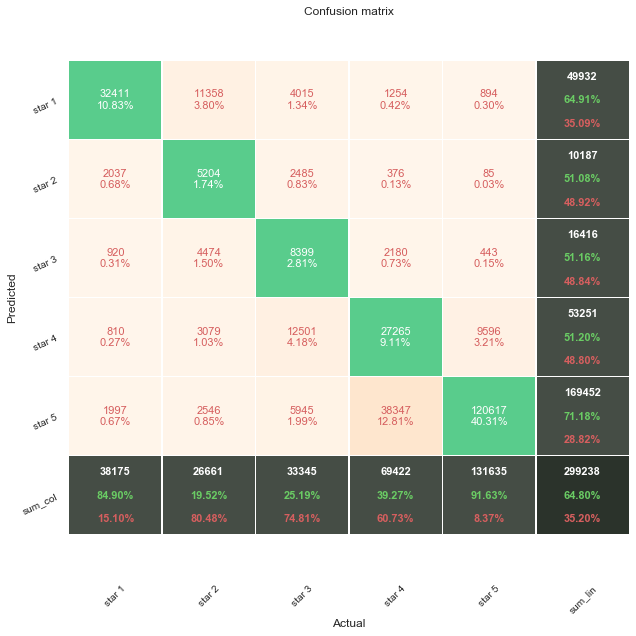

In [149]:
# col_names = ['star 1', 'star 2', 'star 3', 'star 4', 'star 5']
pretty_plot_confusion_matrix(pd.DataFrame(confusion_matrix(y_test, best_SVC_pred_test_tfidf), columns=col_names, index=col_names))

__comments__: Text classification between given stars and review contents seems to be good. Indeed, f1 score accuracy of only 65% come from middle classes since there are more errors on them. Classes 1 and 5 got really good f1 scores (74% and 80%). This means that words used in extreme bad and good reviews are distinctable. Errors of missclassification are mostly around adjacent classes (between stars 1 and 2 and between star 4 and 5) and rarely between star 1 and 5 (0.3 % and 0.67%)

__Does adding emoticons sentiment and polarity improves the model?__

We have seen that sentiment analysis through emoticons may give helpful insights.

In [124]:
#we add 2 new columns of binary outputs from emoticons analysis at the initial tf-idf matrix

best_tfidf_emj_train = hstack((best_tfidf_train, np.array(X_train['happy'])[:,None]))
best_tfidf_emj_train = hstack((best_tfidf_emj_train, np.array(X_train['sad'])[:,None]))

best_tfidf_emj_test = hstack((best_tfidf_test, np.array(X_test['happy'])[:,None]))
best_tfidf_emj_test = hstack((best_tfidf_emj_test, np.array(X_test['sad'])[:,None]))

In [125]:
best_SVC_tfidf_2 = LinearSVC(C=0.01).fit(best_tfidf_emj_train, y_train)
best_SVC_pred_test_tfidf_2 = best_SVC_tfidf_2.predict(best_tfidf_emj_test)

In [126]:
print('Best SVM + emojis - classification report on test')
print(classification_report(y_test, best_SVC_pred_test_tfidf_2))

Best SVM + emojis - classification report on test
              precision    recall  f1-score   support

           1       0.65      0.85      0.74     38175
           2       0.51      0.20      0.28     26661
           3       0.51      0.25      0.34     33345
           4       0.51      0.39      0.44     69422
           5       0.71      0.92      0.80    131635

    accuracy                           0.65    299238
   macro avg       0.58      0.52      0.52    299238
weighted avg       0.62      0.65      0.61    299238



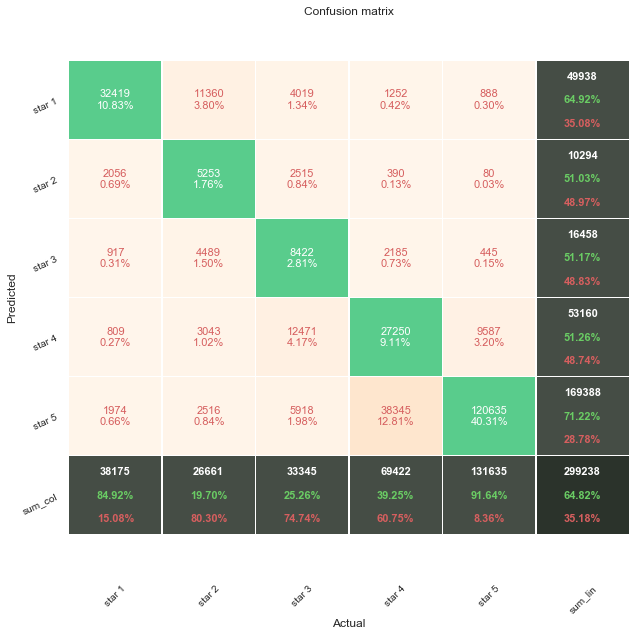

In [148]:
pretty_plot_confusion_matrix(pd.DataFrame(confusion_matrix(y_test, best_SVC_pred_test_tfidf_2), columns=col_names, index=col_names))

__comment__: Basically, adding emoticons does not improve significantly text classification accuracy.

----
we can conclude from this reseach that Yelp does not seem to contain missclassifications and besides 6% of errors in average computation, the overall star per business is meaningfull. However, this does not mean those reviews were written as non-fake reviews, but this could be another interesting research direction.

# 5. Yelp a powerful indicator in Arizona? - Open/close information perspective

In the last part of the study, we want to find out to what extent Yelp is a powerful indicator by giving significant information. Thus, we will try to predict whether a restaurant had closed or is still open. 

In [260]:
_arizona_case_business_info = arizona_case_business_info.copy()

In [261]:
_arizona_case_business_info.head(3)

name  review_count  is_open  \
business_id                                                           
--Rsj71PBe31h5YljVseKA              Circle K             9        1   
-01XupAWZEXbdNbxNg5mEg            18 Degrees            99        1   
-050d_XIor1NpCuWkbIVaQ  Matt's Big Breakfast           703        0   

                                                               attributes  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA  {'OutdoorSeating': 'False', 'RestaurantsTakeOu...   
-01XupAWZEXbdNbxNg5mEg  {'RestaurantsGoodForGroups': 'True', 'Music': ...   
-050d_XIor1NpCuWkbIVaQ  {'Corkage': 'False', 'RestaurantsReservations'...   

                        ratio_stars_review  overall_star  true_mean_stars  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA            0.388889           3.5         3.200000   
-01XupAWZEXbdNbxNg5mEg            0.030303           3.0         3.067961   
-050d_XIor1NpCuWkbIVaQ            0.005690           4.0         3.995862   

                        true_std_stars  true_median_stars  true_iqr_stars  \
business_id                                                                 
--Rsj71PBe31h5YljVseKA        1.751190                4.0             3.5   
-01XupAWZEXbdNbxNg5mEg        1.450234                3.0             2.0   
-050d_XIor1NpCuWkbIVaQ        1.111832                4.0             2.0   

                        ...  age_in_yelp_d  min_between_reviews_in_h  \
business_id             ...                                            
--Rsj71PBe31h5YljVseKA  ...         2450.0                     171.0   
-01XupAWZEXbdNbxNg5mEg  ...         3330.0                       0.0   
-050d_XIor1NpCuWkbIVaQ  ...         4201.0                       0.0   

                        max_between_reviews_in_h  \
business_id                                        
--Rsj71PBe31h5YljVseKA                   22420.0   
-01XupAWZEXbdNbxNg5mEg                    4799.0   
-050d_XIor1NpCuWkbIVaQ                   15805.0   

                        average_between_reviews_in_h  \
business_id                                            
--Rsj71PBe31h5YljVseKA                        6534.0   
-01XupAWZEXbdNbxNg5mEg                         783.0   
-050d_XIor1NpCuWkbIVaQ                         139.0   

                        average_between_reviews_in_h_binned  price_range  \
business_id                                                                
--Rsj71PBe31h5YljVseKA                                    8          2.0   
-01XupAWZEXbdNbxNg5mEg                                    6          2.0   
-050d_XIor1NpCuWkbIVaQ                                    3          1.0   

                        take_out  delivery  isCarParking  nb_similar  
business_id                                                           
--Rsj71PBe31h5YljVseKA       1.0       NaN           0.0         134  
-01XupAWZEXbdNbxNg5mEg       1.0       0.0           0.0           1  
-050d_XIor1NpCuWkbIVaQ       1.0       0.0           1.0           5  

[3 rows x 28 columns]

## 5.1 Variables versus target

### 5.1.1 Data featuring

Throughout the study, we manage to create siginificant features among time, space and research around the ratio stars/ reviews. However, the fact that a restaurant close or is still open may come from external features to Yelp, such as the price of the service, the rent (this in particular is included in the feature created earlier of the distance to city center), how a restaurant can extend their revenus (take out and delivery), is a restaurant is easily accessible. These information are inclused in the initial feature called 'attributes'.

- source = 'https://restaurantengine.com/great-restaurant-location/'
- 'https://www.thebalancesmb.com/choosing-restaurant-location-2888543'
- 'https://www.inc.com/jeff-haden/how-to-find-the-perfect-location-for-a-new-restaurant-6-ways.html'

__price range__

In [262]:
price_range = []

for ind, i in enumerate(_arizona_case_business_info.attributes.values):
    if i:
        if 'RestaurantsPriceRange2' in i:
            if i['RestaurantsPriceRange2'] and i['RestaurantsPriceRange2']!='None':
                price_range.append(int(i['RestaurantsPriceRange2']))
            else:
                price_range.append(np.nan)
        else:
            price_range.append(np.nan)
    else:
        price_range.append(np.nan)

_arizona_case_business_info['price_range'] = price_range

__takeout__

In [263]:
def to_binary(sent):
    sent=sent.lower()
    return 1 if sent=='true' else 0

In [264]:
take_out = []

for ind, i in enumerate(_arizona_case_business_info.attributes.values):
    if i:
        if 'RestaurantsTakeOut' in i:
            if i['RestaurantsTakeOut']:
                take_out.append(to_binary(i['RestaurantsTakeOut']))
            else:
                take_out.append(np.nan)
        else:
            take_out.append(np.nan)
    else:
        take_out.append(np.nan)


_arizona_case_business_info['take_out'] = take_out

__delivery__

In [265]:
delivery = []

for ind, i in enumerate(_arizona_case_business_info.attributes.values):
    if i:
        if 'RestaurantsDelivery' in i:
            if i['RestaurantsDelivery']:
                delivery.append(to_binary(i['RestaurantsDelivery']))
            else:
                delivery.append(np.nan)
        else:
            delivery.append(np.nan)
    else:
        delivery.append(np.nan)

_arizona_case_business_info['delivery'] = delivery

__accessibility__

In [266]:
isCarParking = []
for ind, i in enumerate(_arizona_case_business_info.attributes.values):
    if i:
        if 'BusinessParking' in i:
            dict_ = eval(i['BusinessParking']) 
            if dict_:
                if 'garage' not in dict_ and 'street' not in dict_:
                    isCarParking.append(np.nan)
                elif 'garage' not in dict_ and 'street' in dict_:
                    isCarParking.append(int(dict_['street']))
                elif 'garage' in dict_ and 'street' not in dict_:
                    isCarParking.append(int(dict_['garage']))
                else:
                    isCarParking.append(int(dict_['garage'] | dict_['street']))
            else:
                isCarParking.append(np.nan)
        else:
            isCarParking.append(np.nan)
    else:
        isCarParking.append(np.nan)

_arizona_case_business_info['isCarParking'] = isCarParking

__local or chain__
The number of same restaurants are added. Let's keep in mind that Yelp activity is about Phoenix and its surroundings so the number of similar restaurants in a such small area can have a significant impact.

In [267]:
nb_similar = []

occurences = Counter(_arizona_case_business_info.name)

for name in arizona_case_business_info.name:
    nb_similar.append(occurences[name])

_arizona_case_business_info['nb_similar'] = nb_similar

__target and variables setting__

In [268]:
#summary of all variables created
print(_arizona_case_business_info.columns)

Index(['name', 'review_count', 'is_open', 'attributes', 'ratio_stars_review',
       'overall_star', 'true_mean_stars', 'true_std_stars',
       'true_median_stars', 'true_iqr_stars', 'rounded_mean_stars',
       'difference_of_output_star', 'ratio_w_funny_reviews',
       'ratio_w_cool_reviews', 'ratio_w_useful_reviews',
       'dist_to_phoenix_city_center', 'min_dist_tourist_attraction',
       'born_in_yelp_d', 'age_in_yelp_d', 'min_between_reviews_in_h',
       'max_between_reviews_in_h', 'average_between_reviews_in_h',
       'average_between_reviews_in_h_binned', 'price_range', 'take_out',
       'delivery', 'isCarParking', 'nb_similar'],
      dtype='object')


In [269]:
#choice of variables for prediction :

target = ['is_open']

#continuous
var_continuous = ['ratio_stars_review', 
                  'ratio_w_funny_reviews', 
                  'ratio_w_useful_reviews', 
                  'dist_to_phoenix_city_center', 
                  'min_dist_tourist_attraction',
                  'true_std_stars',
                 ]
#discrete or categorical
var_discrete = [ 'review_count',
                'overall_star',
                'true_iqr_stars',
                'true_median_stars',
                'difference_of_output_star',
                'average_between_reviews_in_h_binned',
                'min_between_reviews_in_h',
                'max_between_reviews_in_h',
                'born_in_yelp_d',
                'age_in_yelp_d',
                'price_range',
                'nb_similar',
                'take_out',
               'delivery',
               'isCarParking',
               ]
clf_var = var_continuous + var_discrete

### 5.1.2 missing values and data selection

In [270]:
print(_arizona_case_business_info[clf_var].isnull().sum())
print('----------------------------------------------')
print('total of obs', _arizona_case_business_info.count()[0])

ratio_stars_review                        0
ratio_w_funny_reviews                     0
ratio_w_useful_reviews                    0
dist_to_phoenix_city_center               0
min_dist_tourist_attraction               0
true_std_stars                            0
review_count                              0
overall_star                              0
true_iqr_stars                            0
true_median_stars                         0
difference_of_output_star                 0
average_between_reviews_in_h_binned       0
min_between_reviews_in_h                  0
max_between_reviews_in_h                  0
born_in_yelp_d                            0
age_in_yelp_d                             0
price_range                             815
nb_similar                                0
take_out                               1377
delivery                               2718
isCarParking                           1551
dtype: int64
----------------------------------------------
total of obs 106

__comments__ : with the last new features created, missing values were included in the dataframe. Let's see of those missing values depend on the same businesses

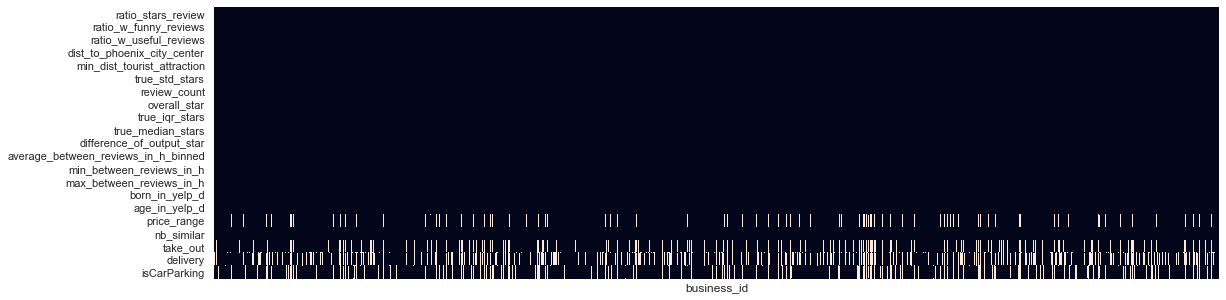

In [271]:
plt.figure(figsize=(18,5))
sns.heatmap(_arizona_case_business_info[clf_var].isnull().transpose(), cbar=False, xticklabels=False)
plt.show()

__comment__: The above heat map shows that missing values are usually on the same obversations. Since we have an enough total of 10631 observations and believe that the new features can help in predicting, we drop all missing values.

In [272]:
_arizona_case_business_info.dropna(inplace=True)

In [273]:
_arizona_case_business_info[target + clf_var].describe()

is_open  ratio_stars_review  ratio_w_funny_reviews  \
count  6890.000000         6890.000000            6890.000000   
mean      0.721771            0.120805               0.520355   
std       0.448159            0.193021               0.982881   
min       0.000000            0.001757               0.000000   
25%       0.000000            0.023810               0.242938   
50%       1.000000            0.052632               0.393939   
75%       1.000000            0.128571               0.614193   
max       1.000000            1.666667              71.166667   

       ratio_w_useful_reviews  dist_to_phoenix_city_center  \
count             6890.000000                  6890.000000   
mean                 1.197288                     0.133983   
std                  1.277044                     0.071016   
min                  0.000000                     0.000028   
25%                  0.680000                     0.077192   
50%                  1.000000                     0.133261   
75%                  1.438831                     0.184359   
max                 74.423077                     0.397901   

       min_dist_tourist_attraction  true_std_stars  review_count  \
count                  6890.000000     6890.000000   6890.000000   
mean                      0.071823        1.331303    125.639187   
std                       0.050383        0.290406    188.108857   
min                       0.000136        0.000000      3.000000   
25%                       0.033241        1.181715     24.000000   
50%                       0.060565        1.375106     62.000000   
75%                       0.105776        1.519316    150.000000   
max                       0.280611        2.309401   2556.000000   

       overall_star  true_iqr_stars  ...  average_between_reviews_in_h_binned  \
count   6890.000000     6890.000000  ...                          6890.000000   
mean       3.448186        1.961575  ...                             5.431930   
std        0.783179        1.007278  ...                             1.797345   
min        1.000000        0.000000  ...                             1.000000   
25%        3.000000        1.000000  ...                             4.000000   
50%        3.500000        2.000000  ...                             5.000000   
75%        4.000000        3.000000  ...                             7.000000   
max        5.000000        4.000000  ...                             8.000000   

       min_between_reviews_in_h  max_between_reviews_in_h  born_in_yelp_d  \
count               6890.000000               6890.000000     6890.000000   
mean                 143.141074               7586.649637     2432.766328   
std                  923.141113               7944.282273     1238.724366   
min                    0.000000                  9.000000        0.000000   
25%                    0.000000               1826.000000     1363.000000   
50%                    1.000000               5043.000000     2341.000000   
75%                   24.000000              10538.250000     3456.000000   
max                30433.000000              70999.000000     4894.000000   

       age_in_yelp_d  price_range   nb_similar     take_out     delivery  \
count    6890.000000  6890.000000  6890.000000  6890.000000  6890.000000   
mean     2143.106096     1.523367    20.123222     0.964151     0.203048   
std      1292.437157     0.560045    48.525021     0.185927     0.402297   
min         0.000000     1.000000     1.000000     0.000000     0.000000   
25%       983.250000     1.000000     1.000000     1.000000     0.000000   
50%      2050.000000     1.000000     1.000000     1.000000     0.000000   
75%      3235.750000     2.000000    14.000000     1.000000     0.000000   
max      4998.000000     4.000000   263.000000     1.000000     1.000000   

       isCarParking  
count   6890.000000  
mean       0.128882  
std        0.335094  
min        0.000000  
25%        0.000000  
50%        0

In [274]:
_arizona_case_business_info[target + clf_var].head()

is_open  ratio_stars_review  ratio_w_funny_reviews  \
business_id                                                                  
-01XupAWZEXbdNbxNg5mEg        1            0.030303               0.606061   
-050d_XIor1NpCuWkbIVaQ        0            0.005690               0.937411   
-0Sgh0QlUKVsWosCWJzGqQ        1            0.042553               0.574468   
-0WegMt6Cy966qlDKhu6jA        1            0.020000               0.280000   
-0tgMGl7D9B10YjSN2ujLA        1            0.026923               0.469231   

                        ratio_w_useful_reviews  dist_to_phoenix_city_center  \
business_id                                                                   
-01XupAWZEXbdNbxNg5mEg                1.484848                     0.215460   
-050d_XIor1NpCuWkbIVaQ                1.910384                     0.008330   
-0Sgh0QlUKVsWosCWJzGqQ                0.851064                     0.070987   
-0WegMt6Cy966qlDKhu6jA                0.680000                     0.003728   
-0tgMGl7D9B10YjSN2ujLA                1.315385                     0.167244   

                        min_dist_tourist_attraction  true_std_stars  \
business_id                                                           
-01XupAWZEXbdNbxNg5mEg                     0.039541        1.450234   
-050d_XIor1NpCuWkbIVaQ                     0.014057        1.111832   
-0Sgh0QlUKVsWosCWJzGqQ                     0.034841        1.391788   
-0WegMt6Cy966qlDKhu6jA                     0.012958        1.159733   
-0tgMGl7D9B10YjSN2ujLA                     0.057784        1.365921   

                        review_count  overall_star  true_iqr_stars  ...  \
business_id                                                         ...   
-01XupAWZEXbdNbxNg5mEg            99           3.0             2.0  ...   
-050d_XIor1NpCuWkbIVaQ           703           4.0             2.0  ...   
-0Sgh0QlUKVsWosCWJzGqQ            47           2.0             2.0  ...   
-0WegMt6Cy966qlDKhu6jA           100           2.0             2.0  ...   
-0tgMGl7D9B10YjSN2ujLA           130           3.5             2.0  ...   

                        average_between_reviews_in_h_binned  \
business_id                                                   
-01XupAWZEXbdNbxNg5mEg                                    6   
-050d_XIor1NpCuWkbIVaQ                                    3   
-0Sgh0QlUKVsWosCWJzGqQ                                    7   
-0WegMt6Cy966qlDKhu6jA                                    5   
-0tgMGl7D9B10YjSN2ujLA                                    6   

                        min_between_reviews_in_h  max_between_reviews_in_h  \
business_id                                                                  
-01XupAWZEXbdNbxNg5mEg                       0.0                    4799.0   
-050d_XIor1NpCuWkbIVaQ                       0.0                   15805.0   
-0Sgh0QlUKVsWosCWJzGqQ                       2.0                   12159.0   
-0WegMt6Cy966qlDKhu6jA                       0.0                    4876.0   
-0tgMGl7D9B10YjSN2ujLA                       0.0                    8426.0   

                        born_in_yelp_d  age_in_yelp_d  price_range  \
business_id                                                          
-01XupAWZEXbdNbxNg5mEg          1666.0         3330.0          2.0   
-050d_XIor1NpCuWkbIVaQ           430.0         4201.0          1.0   
-0Sgh0QlUKVsWosCWJzGqQ          1824.0         3146.0          1.0   
-0WegMt6Cy966qlDKhu6jA          2961.0         1982.0          2.0   
-0tgMGl7D9B10YjSN2ujLA           355.0         4611.0          2.0   

                        nb_similar  take_out  delivery  isCarParking  
business_id                                                           
-01XupAWZEXbdNbxNg5mEg           1       1.0       0.0           0.0  
-050d_XIor1NpCuWkbIVaQ           5       1.0       0.0           1.0  
-0Sgh0QlUKVsWosCWJzGqQ          59       1.0       1.0           0.0  
-0WegMt6Cy966qlDKhu6jA           1       0.0       0.0          

__comments__: now we have a sample of 6890 rows. standard deviations and means are quite sparsed between features so we will consider scaling the features before modelling. 

### 5.1.3 Open/close overview

Before applying the model and going deeper in feature analysis, this part helps us to have a helpful overview of the data. do we have an imbalanced case ? How the data look like ?

__count plot__

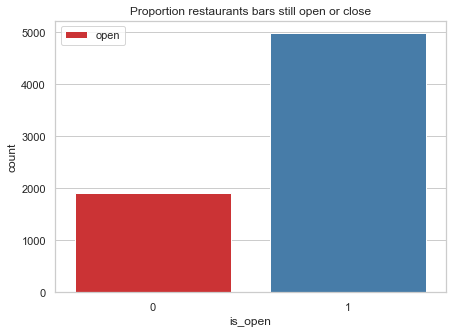

In [275]:
plt.figure(figsize=(7,5))
sns.countplot(x="is_open", data=_arizona_case_business_info, palette='Set1')
plt.title('Proportion restaurants bars still open or close')
plt.legend({'open','close'})
plt.show()

__comments__: closed is a bit imbalanced compared to open which is not suprising. Undersampling is not required in this case considering the amount of observations. However, We may need to consider a classification model that is not weak against a slight imbalanced case. 

__T sne visualization__

T sne is used as a dimension reduction model for visualization. It's really helpful when the dataset has natural clusters because T sne helps keepping those clusters while plotting in 2D or 3D. This is something that PCA may does not. 

In [276]:
tsne = TSNE(n_components=2, perplexity=60).fit_transform(_arizona_case_business_info[clf_var])
df_tsne = pd.DataFrame({'first_component': tsne[:,0], 'second_component': tsne[:,1]})
df_tsne['is_open'] = _arizona_case_business_info.is_open.values

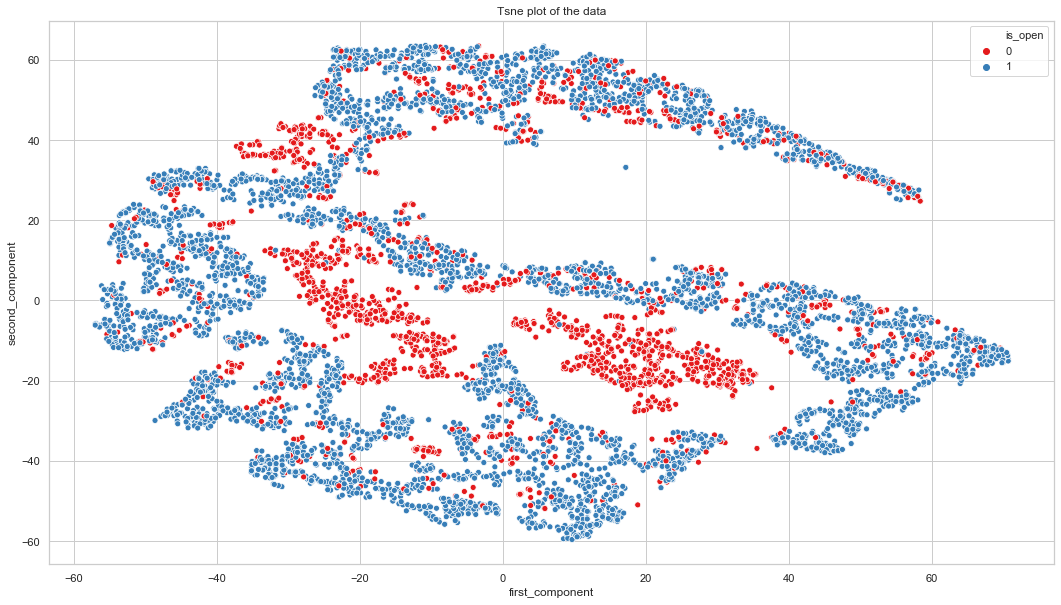

In [277]:
plt.figure(figsize=(18,10))
sns.scatterplot(x='first_component', y='second_component', data=df_tsne, hue='is_open', palette='Set1')
plt.title('Tsne plot of the data')
plt.show()

__comment__: this is a really interesting plot. Tsne is able to show local structures within the data among the close/open information ! We can see that T sne highlighted by keeping natural clusters, the actual open vs close categories. Hence, it's a good first feeling regarding the potential success of the classification model.

### 5.1.4 Correlation

Before applying any kind of models, it's important to check correlation among features. Indeed some models might fail against multicollinearity.

__Spearman within continuous variables where linearity is not assumed__

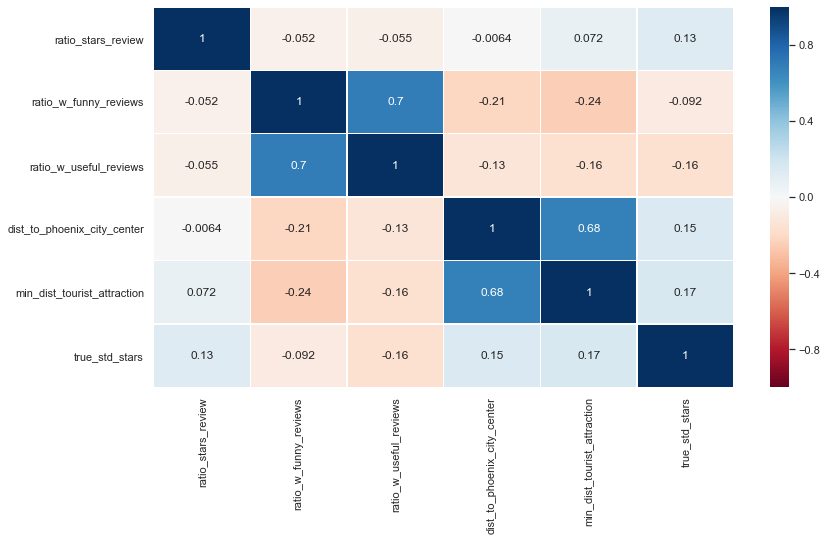

In [278]:
plt.figure(figsize=(13,7))
sns.heatmap(_arizona_case_business_info[var_continuous].corr(method='spearman'), annot=True, linewidths=.5, cmap="RdBu", cbar=True, vmin=-1, vmax=1)
plt.show()

__comments__: Regarding continuous data, correlation can often be measured through Pearson computation or Spearman. While Pearson assumes linear relationship between variables, Spearman does not. In fact Spearman correlation gives advantages such as capturing monotonic relations and being more robust against outliers. In our case, we do not assume any linear relationship especially between Harversine distances and so Spearman correlation is computed. The correlation matrix above shows that there is a bit of correlation between the two indicators of reviews and between the two distances. This seems natural since those variables are derived from the same feature. However, it doesn't reach 0.9 correlation and we do not need to consider mutlicollinearity within features so far.

__Cramer's V correlation within discrete variables__

In [279]:
#source : https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [280]:
mat_cramer_v = np.zeros((len(var_discrete + target),len(var_discrete + target)))
for iv, v in enumerate(var_discrete + target):
    for ivv, vv in enumerate(var_discrete + target):
        mat_cramer_v[iv, ivv] = cramers_v(_arizona_case_business_info[v].values, _arizona_case_business_info[vv].values)

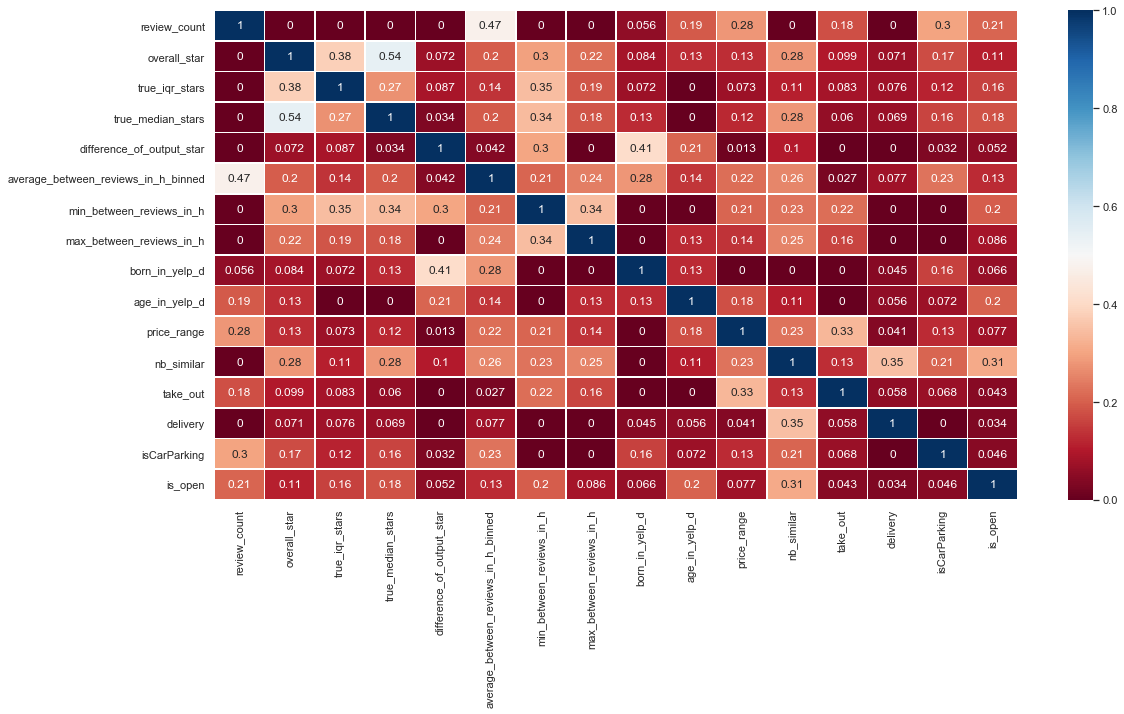

In [281]:
plt.figure(figsize=(18,9))
sns.heatmap(pd.DataFrame(mat_cramer_v, index=var_discrete + target, columns=var_discrete + target), annot=True, linewidths=.5, cmap="RdBu", cbar=True, vmin=0, vmax=1)
plt.show()

__comments__: Regarding correlation between discrete variables, ie categorical or ordinal, it can be measured by Goodman Kruskal's lambda, Phi Coefficient or Cramer's V. They all use a Chi-2 statistical test. Cramer's V is computed above and outputs are shown in the matrix. Unlike Spearman or Pearson that are bounded by -1 and 1, Cramer's V goes from 0 to 1, where 0 means no relationship. The output shows that there is no correlation within these discrete features.

__Point biserial correlation between continuous and discrete__

In [282]:
mat_pointbiserialr = np.zeros((len(var_continuous),len(var_discrete + target)))
for idx, i in enumerate(var_continuous):
    for jdx, j in enumerate(var_discrete + target):
        mat_pointbiserialr[idx,jdx] = stats.pointbiserialr(_arizona_case_business_info[i].values, _arizona_case_business_info[j].values)[0]

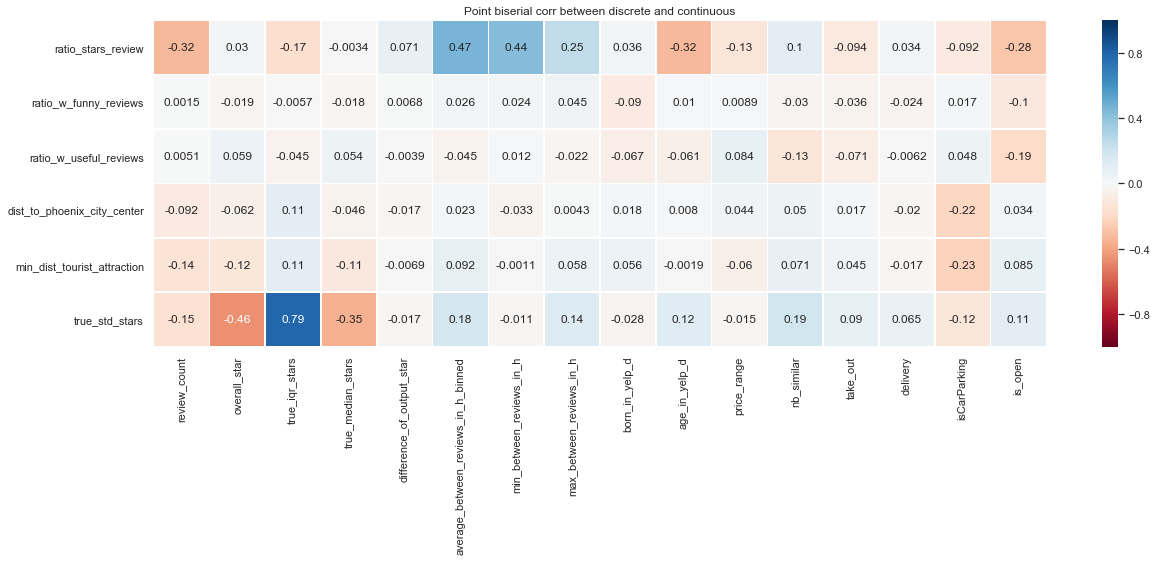

In [283]:
plt.figure(figsize=(20,6))

sns.heatmap(pd.DataFrame(mat_pointbiserialr, index=var_continuous, columns=var_discrete + target), annot=True, linewidths=.5, cmap="RdBu", cbar=True, vmin=-1, vmax=1)
plt.title('Point biserial corr between discrete and continuous')

plt.show()

__comments__: Finally, to close the correlation analysis loop, it's important to compute the correlation between the continous and discrete variables. This is done by Point Biserial correlation computation. The highest correlation is between true std star and true iqr star but remains at 0.79. This is clearly natural, since those features explain the stars feature dispersion. Again there is extreme high correlation throughout correlations so we do not need to remove features or use a model handling multicollinearity. 

### 5.1.5 Outliers - mahalanobis distance

T-sne didn't show any outlier, However we still compute the mahalanobis distance to know a bit more. Mahalanobis distance allows to compute a mutli dimensional distance as it takes in account the covariance matrix and the mean vector of all data. 

In [284]:
meanV = _arizona_case_business_info[clf_var].mean().values.reshape(1, len(clf_var))
mahalanobis_dist = cdist(_arizona_case_business_info[clf_var], meanV, metric='mahalanobis').flatten()

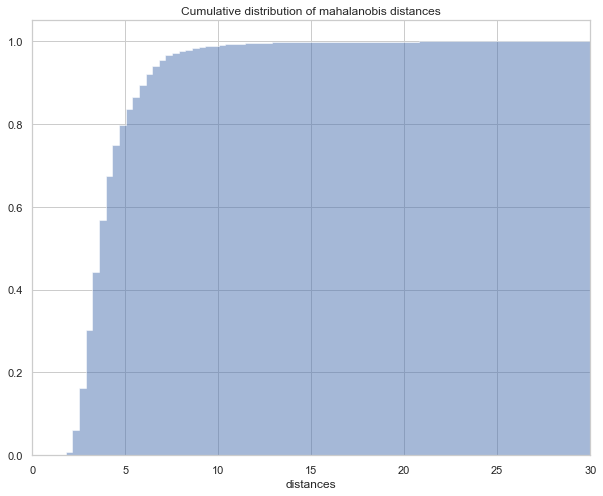

In [285]:
plt.figure(figsize=(10,8))
plt.hist(mahalanobis_dist, cumulative=True, density=True, histtype='stepfilled',  bins=200, alpha=0.5)
plt.title('Cumulative distribution of mahalanobis distances')
plt.xlim(0, 30)
plt.xlabel('distances')
plt.show()

__comments__ : even though T sne showed barely outliers, we can still remove some rows in order to slightly improve the model accuracy. The cumulative distribution above shows that around 1% of data have a mahalanobis distance greater than 10. So we will keep those having a distance below or equal to 10.

In [286]:
#we remove rows that have a mahalanobis_dist>10
_arizona_case_business_info = _arizona_case_business_info[mahalanobis_dist<=10]

In [287]:
print('new size of the dataset:', _arizona_case_business_info.shape)

new size of the dataset: (6815, 28)


### 5.1.6 What does pca tell us ?

when we have a large amount of features, it's always interesting to perform a PCA to have an idea about the variance explained from those features

In [288]:
#scaling before using pca
A = StandardScaler().fit_transform(_arizona_case_business_info[var_continuous]) # we fit on train
B = MinMaxScaler().fit_transform(_arizona_case_business_info[var_discrete])
A_B = pd.DataFrame(np.concatenate((A, B), axis=1))

#pca
pca = PCA(n_components=len(clf_var)).fit(A_B)
print(np.cumsum(pca.explained_variance_ratio_))

[0.30712593 0.52196533 0.6789051  0.81908605 0.86675238 0.90364541
 0.92745455 0.94850965 0.96283315 0.97595981 0.98187691 0.98650403
 0.99004298 0.99295887 0.99572142 0.99699116 0.99791575 0.99875413
 0.9992591  0.99972021 1.        ]


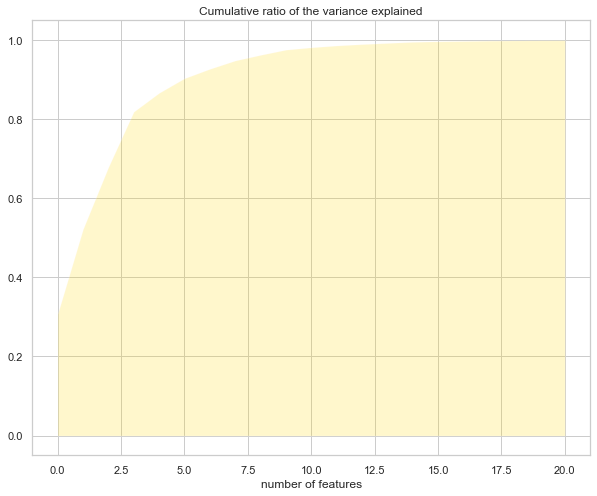

In [289]:
plt.figure(figsize=(10,8))
plt.fill_between(x=range(0,len(clf_var)), y1=np.cumsum(pca.explained_variance_ratio_), facecolor="gold", alpha=0.2)
plt.title('Cumulative ratio of the variance explained')
plt.xlabel('number of features')
plt.show()

__comments__: with only 2 components, more than 50% of the variance of the dataset is explained. 11 components reaches 98% of total explained variance. Using pca could allow us to improve the classification accuracy. However the features will be less interpretable.

### 5.2 Models and predictions

In this part, we will perform the prediction of the binary target open/close. So far we found out that in our dataset we have : 
- no high correlation 
- a bit of imbalanced
- mutli type of data

### 5.2.1 preparation

__splitting__

In [290]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(_arizona_case_business_info[clf_var], _arizona_case_business_info[target], test_size=0.3, random_state = 42, shuffle=True, stratify=_arizona_case_business_info[target])

In [291]:
print(X_train_2.shape)
print(X_test_2.shape)

(4770, 21)
(2045, 21)


__scaling__

In [292]:
#standard scaling for continuous
z_scaler = StandardScaler().fit(X_train_2[var_continuous]) # we fit on train
continuous_train_scaled = z_scaler.transform(X_train_2[var_continuous]) # we transform on train
continuous_test_scaled = z_scaler.transform(X_test_2[var_continuous]) # we transform on test

#min max scaling for discrete
mm_scaler = MinMaxScaler().fit(X_train_2[var_discrete])
discrete_train_scaled = mm_scaler.transform(X_train_2[var_discrete]) # we transform on train
discrete_test_scaled = mm_scaler.transform(X_test_2[var_discrete]) # we transform on test

In [293]:
X_train_2_scaled = pd.DataFrame(np.concatenate((continuous_train_scaled, discrete_train_scaled), axis=1), columns=[var_continuous + var_discrete], index=X_train_2.index)
X_test_2_scaled = pd.DataFrame(np.concatenate((continuous_test_scaled, discrete_test_scaled), axis=1), columns=[var_continuous + var_discrete], index=X_test_2.index)

In [294]:
X_train_2_scaled.describe()

ratio_stars_review ratio_w_funny_reviews ratio_w_useful_reviews  \
count       4.770000e+03          4.770000e+03           4.770000e+03   
mean       -1.251270e-16          8.267321e-17           7.001155e-17   
std         1.000105e+00          1.000105e+00           1.000105e+00   
min        -6.441377e-01         -1.120476e+00          -1.504013e+00   
25%        -5.230400e-01         -5.767683e-01          -6.331108e-01   
50%        -3.560637e-01         -2.402782e-01          -2.022523e-01   
75%         7.421534e-02          2.601303e-01           3.624583e-01   
max         7.866911e+00          1.469374e+01           1.126922e+01   

      dist_to_phoenix_city_center min_dist_tourist_attraction true_std_stars  \
count                4.770000e+03                4.770000e+03   4.770000e+03   
mean                -2.830254e-17               -8.341802e-17  -2.145035e-16   
std                  1.000105e+00                1.000105e+00   1.000105e+00   
min                 -1.903249e+00               -1.424297e+00  -4.789706e+00   
25%                 -7.995156e-01               -7.650620e-01  -5.344173e-01   
50%                 -7.553831e-03               -2.177702e-01   1.468686e-01   
75%                  7.149402e-01                6.683318e-01   6.601828e-01   
max                  3.750687e+00                3.749102e+00   3.480142e+00   

      review_count overall_star true_iqr_stars true_median_stars  ...  \
count  4770.000000  4770.000000    4770.000000       4770.000000  ...   
mean      0.072706     0.610770       0.495073          0.664544  ...   
std       0.102968     0.194608       0.250357          0.295888  ...   
min       0.000000     0.000000       0.000000          0.000000  ...   
25%       0.012963     0.500000       0.250000          0.500000  ...   
50%       0.035802     0.625000       0.500000          0.750000  ...   
75%       0.089506     0.750000       0.750000          1.000000  ...   
max       1.000000     1.000000       1.000000          1.000000  ...   

      average_between_reviews_in_h_binned min_between_reviews_in_h  \
count                         4770.000000              4770.000000   
mean                             0.635759                 0.013110   
std                              0.255868                 0.058101   
min                              0.000000                 0.000000   
25%                              0.428571                 0.000000   
50%                              0.571429                 0.000127   
75%                              0.857143                 0.003155   
max                              1.000000                 1.000000   

      max_between_reviews_in_h born_in_yelp_d age_in_yelp_d  price_range  \
count              4770.000000    4770.000000   4770.000000  4770.000000   
mean                  0.121574       0.496150      0.427548     0.173655   
std                   0.127271       0.253652      0.260193     0.185718   
min                   0.000000       0.000000      0.000000     0.000000   
25%                   0.027855       0.277288      0.195518     0.000000   
50%                   0.081614       0.479586      0.408741     0.000000   
75%                   0.169389       0.703632      0.642655     0.333333   
max                   1.000000       1.000000      1.000000     1.000000   

        nb_similar     take_out     delivery isCarParking  
count  4770.000000  4770.000000  4770.000000  4770.000000  
mean      0.074009     0.966457     0.207757     0.131237  
std       0.184947     0.180068     0.405744     0.337695  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     1.000000     0.000000     0.000000  
50%       0.000000     1.000000     0.000000     0.000000  
75%       0.049618     1.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000  

[8 rows x 21 columns]

### 5.2.1 Logistic regression

- Logistic regression does not require a linear relationship between the dependent and independent variables.  
- Second, the error terms (residuals) do not need to be normally distributed.  Third, homoscedasticity is not required.
- logistic regression requires the observations to be independent of each other
- logistic regression requires there to be little or no multicollinearity among the independent variables

In [295]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train_2_scaled, y_train_2.values.flatten())

lr_pred_train = lr.predict(X_train_2_scaled)
lr_pred_test = lr.predict(X_test_2_scaled)

In [296]:
print('Logistic Regression on train: ')
print(classification_report(y_train_2.values, lr_pred_train))
print()
print('Logistic Regression on test: ')
print(classification_report(y_test_2.values, lr_pred_test))

Logistic Regression on train: 
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      1322
           1       0.90      0.99      0.94      3448

    accuracy                           0.91      4770
   macro avg       0.93      0.85      0.88      4770
weighted avg       0.92      0.91      0.91      4770


Logistic Regression on test: 
              precision    recall  f1-score   support

           0       0.96      0.69      0.80       567
           1       0.89      0.99      0.94      1478

    accuracy                           0.91      2045
   macro avg       0.93      0.84      0.87      2045
weighted avg       0.91      0.91      0.90      2045



__comments__ : Logistic regression provides a really good accuracy. It manages to reach 91% of weighted f1 score accuracy. 

### 5.2.2 Random Forest

- handle large data sets with higher dimensionality and any type of features
- Further, the model outputs importance of variable, which can be a very handy feature.
- It has methods for balancing errors in data sets where classes are imbalanced.
- Decorrelates trees (relative to bagged trees) / important when dealing with mulitple features which may be correlated

In [297]:
rf = RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_depth=100, 
                            min_samples_split=4, 
                            min_samples_leaf=2,
                            max_features='auto', 
                            max_leaf_nodes=None, 
                            random_state=42 )

rf.fit(X_train_2_scaled, y_train_2.values.flatten())

rf_pred_train = rf.predict(X_train_2_scaled)
rf_pred_test = rf.predict(X_test_2_scaled)

In [298]:
print('RF on train: ')
print(classification_report(y_train_2.values, rf_pred_train))
print()
print('RF on test: ')
print(classification_report(y_test_2.values, rf_pred_test))

RF on train: 
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1322
           1       0.99      1.00      0.99      3448

    accuracy                           0.99      4770
   macro avg       0.99      0.98      0.99      4770
weighted avg       0.99      0.99      0.99      4770


RF on test: 
              precision    recall  f1-score   support

           0       0.94      0.72      0.82       567
           1       0.90      0.98      0.94      1478

    accuracy                           0.91      2045
   macro avg       0.92      0.85      0.88      2045
weighted avg       0.91      0.91      0.91      2045



__comment__: as well as Logistic regression, Random Forest also reach a really high accuracy score.

### 5.2.3 Summary

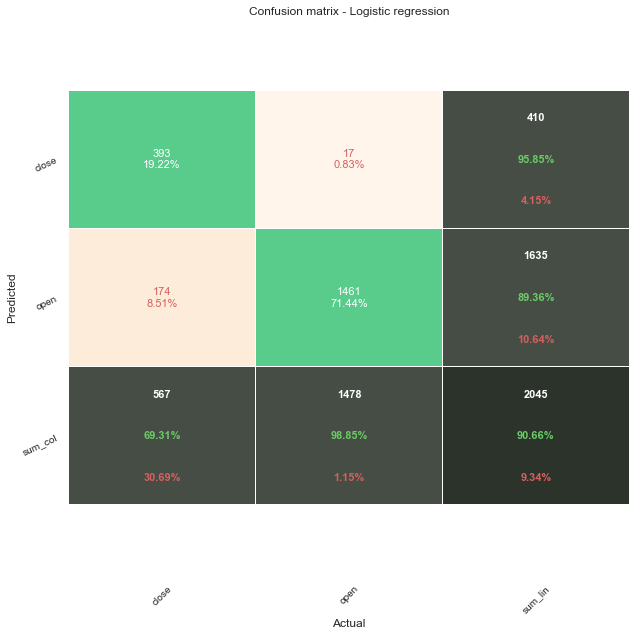

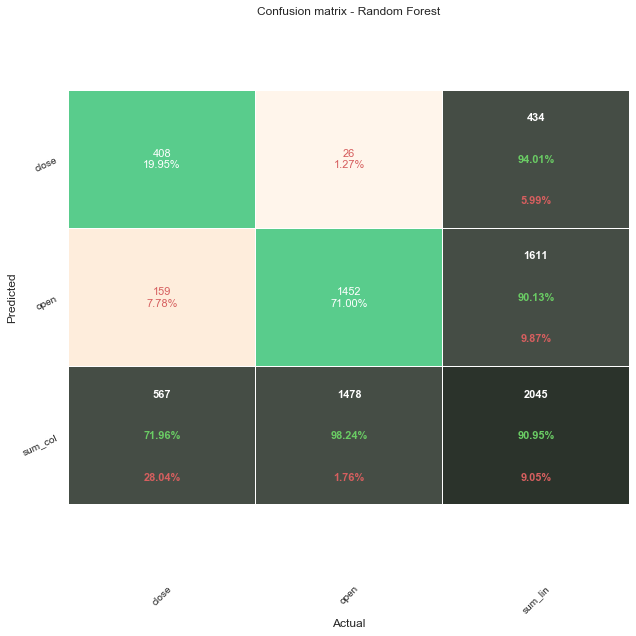

In [299]:
pretty_plot_confusion_matrix(pd.DataFrame(confusion_matrix(y_test_2, lr_pred_test), columns=['close', 'open'], index=['close', 'open']), title='Confusion matrix - Logistic regression')
pretty_plot_confusion_matrix(pd.DataFrame(confusion_matrix(y_test_2, rf_pred_test), columns=['close', 'open'], index=['close', 'open']), title='Confusion matrix - Random Forest')

__comment__: errors are mostly False positive for both models.

__features importance__

In [300]:
lf_coeff = pd.DataFrame(lr.coef_.ravel(), columns=['lr_coeff'], index=clf_var).sort_values('lr_coeff', ascending=False)

In [301]:
lf_coeff

lr_coeff
age_in_yelp_d                        13.513212
born_in_yelp_d                       12.371223
review_count                          2.784542
nb_similar                            2.249571
min_between_reviews_in_h              1.285589
min_dist_tourist_attraction           0.226699
true_std_stars                        0.188128
ratio_w_funny_reviews                 0.120162
difference_of_output_star             0.093672
average_between_reviews_in_h_binned  -0.028989
true_median_stars                    -0.034962
ratio_stars_review                   -0.046547
delivery                             -0.132096
dist_to_phoenix_city_center          -0.146449
ratio_w_useful_reviews               -0.281192
isCarParking                         -0.339073
overall_star                         -0.462800
take_out                             -0.580952
max_between_reviews_in_h             -0.874467
price_range                          -0.875888
true_iqr_stars                       -0.923492

In [302]:
rf_feature_importances = pd.DataFrame(rf.feature_importances_, index = clf_var, columns=['importance']).sort_values('importance',ascending=False)

In [303]:
rf_feature_importances

importance
born_in_yelp_d                         0.179153
age_in_yelp_d                          0.163757
ratio_w_useful_reviews                 0.082986
review_count                           0.081051
ratio_stars_review                     0.078989
nb_similar                             0.078504
max_between_reviews_in_h               0.053358
true_std_stars                         0.045542
ratio_w_funny_reviews                  0.042660
min_dist_tourist_attraction            0.036020
dist_to_phoenix_city_center            0.031971
average_between_reviews_in_h_binned    0.025271
true_median_stars                      0.025194
min_between_reviews_in_h               0.023092
true_iqr_stars                         0.017158
overall_star                           0.015907
price_range                            0.009214
delivery                               0.004142
isCarParking                           0.003711
take_out                               0.001224
difference_of_output_star              0.001095

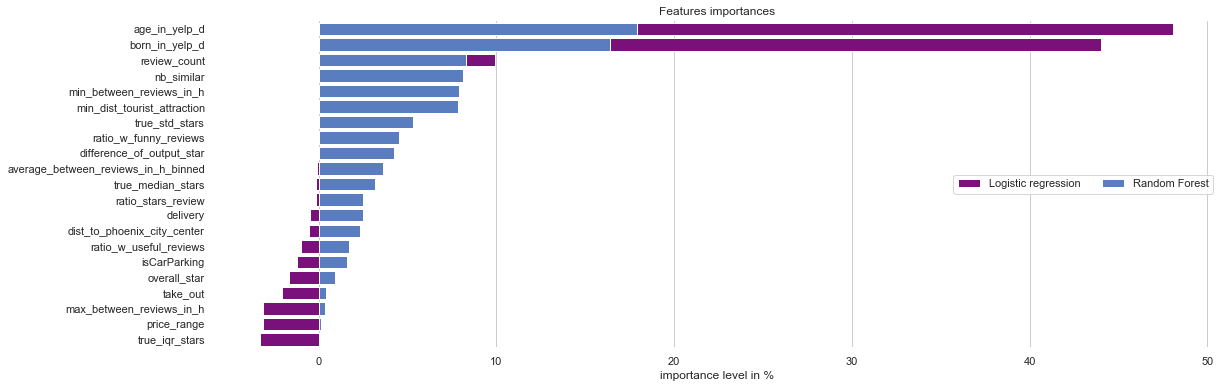

In [305]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(18, 6))
sns.set_color_codes("muted")
sns.barplot(x=(lf_coeff.lr_coeff / lf_coeff.lr_coeff.sum())*100, y=lf_coeff.index,
            label="Logistic regression", color="darkmagenta")

sns.set_color_codes("muted")
sns.barplot(x=(rf_feature_importances.importance / rf_feature_importances.importance.sum())*100, y=lf_coeff.index,
            label="Random Forest", color="b")

ax.legend(ncol=2, loc="right", frameon=True)
ax.set_xlabel('importance level in %')
ax.set_title('Features importances')
sns.despine(left=True, bottom=True)

__comments__: both models gave to time features the highest explanatory level. born_in_yelp_d is the number of days between the beginning of Yelp and the firt review they got. It is therefore information about their registration in the platform. age_in_yelp_d is the number of days between the firt and last review. This explains then how long they last. Thus, It is not surprising that those features have a really good explanatory level. In fact, the number of days between the firt and last review actually could infer biais in the model since in reality, time they last is quite the same information as open and close. We launch again those models without this feature.

__what about without age_in_yelp_d__

In [306]:
__X_train_2_scaled = X_train_2_scaled.drop('age_in_yelp_d', axis=1)
__X_test_2_scaled = X_test_2_scaled.drop('age_in_yelp_d', axis=1)
__clf_var = clf_var
__clf_var.remove('age_in_yelp_d')

In [307]:
lr.fit(__X_train_2_scaled, y_train_2.values.flatten())

__lr_pred_test = lr.predict(__X_test_2_scaled)

rf.fit(__X_train_2_scaled, y_train_2.values.flatten())

__rf_pred_test = rf.predict(__X_test_2_scaled)

In [312]:
print('classification report on test set:')
print('Logistic regression')
print(classification_report(y_test_2.values, __lr_pred_test))
print()
print('Random Forest')
print(classification_report(y_test_2.values, __rf_pred_test))

classification report on test set:
Logistic regression
              precision    recall  f1-score   support

           0       0.82      0.49      0.62       567
           1       0.83      0.96      0.89      1478

    accuracy                           0.83      2045
   macro avg       0.83      0.73      0.75      2045
weighted avg       0.83      0.83      0.81      2045


Random Forest
              precision    recall  f1-score   support

           0       0.84      0.60      0.70       567
           1       0.86      0.96      0.91      1478

    accuracy                           0.86      2045
   macro avg       0.85      0.78      0.80      2045
weighted avg       0.86      0.86      0.85      2045



In [309]:
new_importance = pd.DataFrame(lr.coef_.ravel(), columns=['lr_coeff'], index=__clf_var).sort_values('lr_coeff', ascending=False)
new_importance['RF'] = pd.DataFrame(rf.feature_importances_, index = __clf_var, columns=['importance'])
new_importance

lr_coeff        RF
review_count                         11.065064  0.108814
nb_similar                            3.798378  0.102926
born_in_yelp_d                        3.357614  0.103637
average_between_reviews_in_h_binned   3.295544  0.036917
min_between_reviews_in_h              2.812716  0.038892
max_between_reviews_in_h              2.534211  0.071101
overall_star                          1.692602  0.023411
difference_of_output_star             0.342863  0.001632
true_std_stars                        0.341884  0.063263
true_median_stars                     0.281195  0.032930
min_dist_tourist_attraction           0.246268  0.048422
ratio_w_funny_reviews                 0.112668  0.056451
dist_to_phoenix_city_center          -0.164629  0.043688
delivery                             -0.208934  0.006199
true_iqr_stars                       -0.382169  0.022817
take_out                             -0.435932  0.002186
isCarParking                         -0.455748  0.005179
ratio_w_useful_reviews               -0.466935  0.099953
price_range                          -0.924951  0.013044
ratio_stars_review                   -1.285456  0.118538

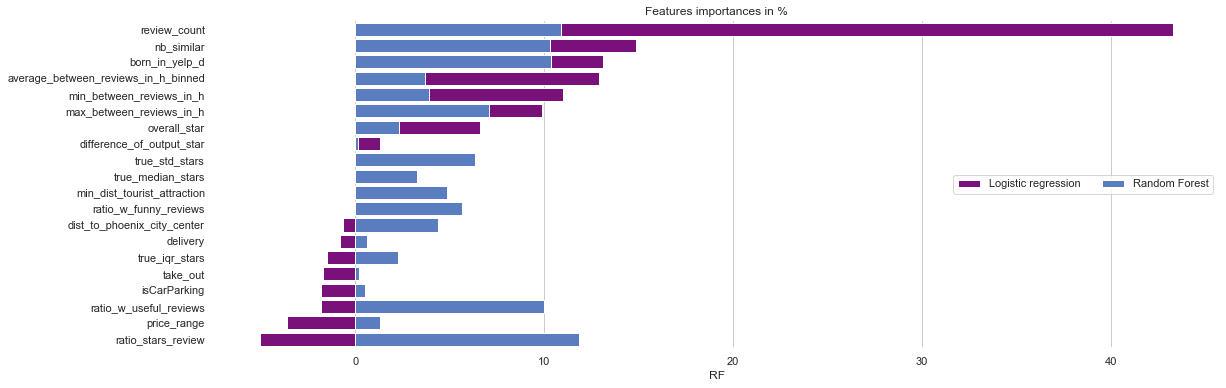

In [310]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(18, 6))
sns.set_color_codes("muted")
sns.barplot(x=(new_importance.lr_coeff / new_importance.lr_coeff.sum())*100, y=new_importance.index,
            label="Logistic regression", color="darkmagenta")

sns.set_color_codes("muted")
sns.barplot(x=(new_importance.RF / new_importance.RF.sum())*100, y=new_importance.index,
            label="Random Forest", color="b")

ax.legend(ncol=2, loc="right", frameon=True)
ax.set_title('Features importances in %')
sns.despine(left=True, bottom=True)

__comment__ : without the feature 'age_in_yelp' that could have inferred biais in the model, feature importance changes while the weighted f1 score accuracy remains good (81% for logistic regression and 85% for random forest). Logistic regression gave to review count, stars given and review frequencies the highest coefficients. Random Forest also used review count and stars given as important features but also captures in born_in_yelp and nb_similar a high level of explanation. 

----
Across models, Yelp is able to make accurate predictions on a closing restaurant based mostly on review count, stars and review frequency. Yelp is then able to explain how attractive a restaurant is. Furthermore, it seems time insights are more powerful than locations. It's likely that time insights from Yelp also hide other external reason of closing. In fact, as we saw before, most of the closed restaurants last 2 years and got registered in Yelp late 2007/2008 and his time is also the beginning of one of the biggest global financial crisis. 